# Plot time series of speed, PDDs, and terminus retreat, fit linear models to peaks 

In [1]:
import xarray as xr
import rioxarray as rxr
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import geopandas as gpd
import scipy
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy.signal import detrend

## Load datasets

Velocities loaded
Weather loaded
Terminus sections loaded
Terminus positions loaded


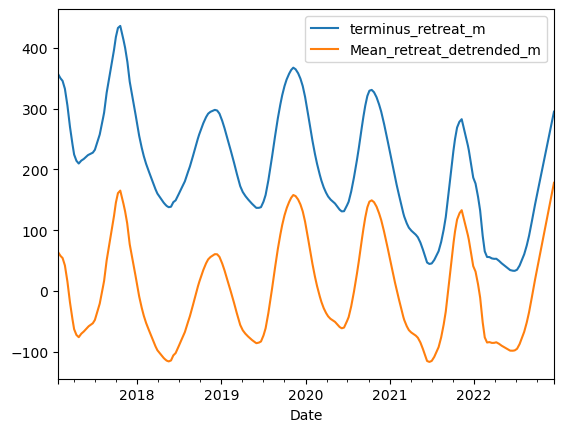

In [2]:
out_path = '/Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/'
data_path = '/Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/'

crs = 'EPSG:3338'

# -----Velocity
#ds_fn = os.path.join(data_path, 'data', 'Hubbard_S1.nc')
ds_fn = os.path.join(data_path, 'data', 'velocity_Radar_2026.nc')

ds = xr.load_dataset(ds_fn)
ds["v"] = np.sqrt(ds.vx**2 + ds.vy**2).fillna(0)
ds["month"] = ds.time.dt.month
ds["year"] = ds.time.dt.year
ds["doy"] = ds.time.dt.dayofyear
ds = ds.rio.write_crs('EPSG:3413')
ds = ds.rio.reproject(crs)
ds = xr.where(ds > 1e10, np.nan, ds)
ds = xr.where(ds==0, np.nan, ds)
ds = ds.rio.write_crs(crs)
print('Velocities loaded')

# -----Air temperature --> PDDs
air_fn = os.path.join(data_path, 'data', 'Yakutat_2000_2023.csv')
air = pd.read_csv(air_fn)
# remove empty columns
air = air[[x for x in list(air.columns) if 'Unnamed' not in x]]
air['Date_Time'] = pd.DatetimeIndex(air['Date_Time'])
air.rename(columns={'Date_Time': 'Date'}, inplace=True)
print('Weather loaded')

# -----Terminus sections
term_sect_fn = os.path.join(data_path, 'data', 'terminus_sections.gpkg')
term_sect = gpd.read_file(term_sect_fn)
term_sect = term_sect.to_crs(crs)
term_sect = term_sect[term_sect['section'].isin(['section_A', 'section_B1', 'section_B2', 'section_C', 'section_D'])].reset_index(drop=True)

print('Terminus sections loaded')

# -----Terminus
term_fn = os.path.join(data_path, 'data', 'terminus_speed_weather.csv')
term = pd.read_csv(term_fn)
term['Date'] = pd.to_datetime(term['Date'])
term.drop_duplicates(inplace=True)

# Calculate the negative to measure retreat as positive
#term['Mean_retreat_m'] = -term['terminus_advance_m']

# Resample to daily
term.set_index('Date', inplace=True)
term = term.resample('1D').interpolate('time')
term.reset_index(inplace=True)

# Detrend terminus retreat
term['Mean_retreat_detrended_m'] = detrend(term['terminus_retreat_m'])
term.set_index('Date')[['terminus_retreat_m', 'Mean_retreat_detrended_m']].plot()
print('Terminus positions loaded')


## Sample speeds at each terminus section, average

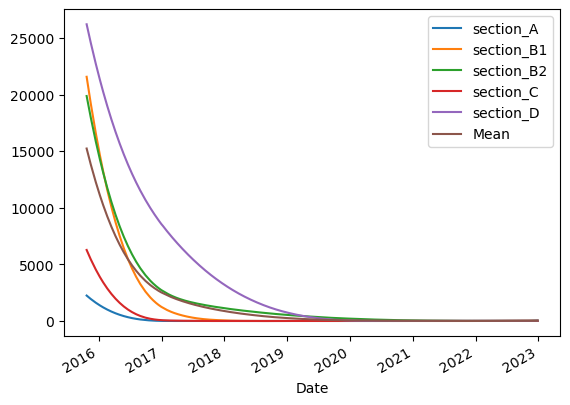

In [5]:
# # Calculate mean speeds in each section
# v_term = pd.DataFrame(columns=['Date'] + list(term_sect['section'].values))
# v_term['Date'] = ds.time.data
# for i in range(0,len(term_sect)):
#     term_sect_i = term_sect.iloc[i,:]
#     # Clip velocity to terminus section
#     v_samp = ds.rio.clip([term_sect_i.geometry])
#     # Average the timeseries in the polygon
#     v_samp_mean = v_samp.mean(dim='x').mean(dim='y').v.data
#     # Add to dataframe
#     v_term[term_sect_i['section']] = v_samp_mean

# # Calculate mean time series in all terminus sections
# v_term.set_index('Date', inplace=True)
# v_term['Mean'] = v_term.mean(axis=1)
# v_term = v_term / 365 # Convert from m/y to m/d
# v_term.plot()
# v_term.reset_index(inplace=True)

# Calculate mean speeds in each section
v_term = pd.DataFrame(columns=['Date'] + list(term_sect['section'].values))

v_term['Date'] = ds.time.data
for i in range(0,len(term_sect)):
    term_sect_i = term_sect.iloc[i,:]
    
    # Clip velocity to terminus section
    v_samp = ds.rio.clip([term_sect_i.geometry])
    
    # Average the timeseries in the polygon
    v_samp_mean = v_samp.mean(dim='x').mean(dim='y').v.data

    # Add to dataframe
    v_term[term_sect_i['section']] = v_samp_mean

# Calculate mean time series in all terminus sections
v_term.set_index('Date', inplace=True)
v_term['Mean'] = v_term.mean(axis=1)
v_term = v_term / 365 # Convert from m/y to m/d
v_term.plot()
v_term.reset_index(inplace=True)

In [33]:
## Calculate annual peaks
# Add fake year columns (starting in April)
def add_fake_year_column(df):
    def calculate_fake_year(month, year):
        # if month <= 0:
        #     return year-1
        # else:
        return year
    months, years = df['Date'].dt.month.values, df['Date'].dt.year.values
    df['fake_year'] = [calculate_fake_year(month, year) 
                        for month, year in list(zip(months, years))]
    return df
def subset_fake_years_add_color(df):
    df = df.loc[(df['fake_year'] >= 2017) & (df['fake_year'] <= 2022)]
    df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
    return df

# PDDs
air = add_fake_year_column(air)
air['fake_year'] = air['fake_year'] + 1
def calculate_pdd(temp):
    if temp > 0:
        return temp
    else:
        return 0

#cumulative PDDs
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)
# print(air)
# air['cumulative_PDD'] = air.groupby(air['Date'].dt.year)['PDD'].cumsum()
# ipeaks = air.groupby(air['fake_year'])['cumulative_PDD'].idxmax().values
# pdd_peaks = air.loc[ipeaks, ['Date', 'cumulative_PDD', 'fake_year']].reset_index(drop=True)
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

#Max PDD
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)
# ipeaks = air.groupby(air['fake_year'])['PDD'].idxmax().values
# pdd_peaks = air.loc[ipeaks, ['Date', 'cumulative_PDD', 'fake_year']].reset_index(drop=True)
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

#first weekly averaged PDD exceeding 9 

# Assuming air['Date'] is already a datetime object
air['Week'] = air['Date'].dt.isocalendar().week
air['Year'] = air['Date'].dt.year

# Group by year and week, and calculate the weekly average
air['fake_year'] = air['Date'].dt.year
air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

air['weekly_PDD'] = air.groupby(['Year', 'Week'])['PDD'].transform('mean')

# Optional: drop the intermediate columns if no longer needed
air = air.drop(columns=['Week', 'Year'])

# Create a mask where the condition weekly_PDD >= threshold is met
mask = (air['weekly_PDD'] <= 12) & (air['Date'].dt.month <= 6) #&(air['Date'].dt.year >= 2017)

# Group by 'fake_year' and find the first index where the threshold is met
ipeaks = air[mask].groupby(air['fake_year'])['weekly_PDD'].idxmax().values
#ipeaks = air.groupby(air['fake_year'])['weekly_PDD'].idxmax().values

pdd_peaks = air.loc[ipeaks, ['Date', 'weekly_PDD', 'fake_year']].reset_index(drop=True)
pdd_peaks = subset_fake_years_add_color(pdd_peaks)

# Terminus retreat
term = add_fake_year_column(term)
ipeaks = term.groupby(term['Date'].dt.year)['Mean_retreat_detrended_m'].idxmin()
term_peaks = term.loc[ipeaks, ['Date', 'Mean_retreat_detrended_m', 'fake_year']].reset_index(drop=True)
term_peaks = subset_fake_years_add_color(term_peaks)

# Speed minimums
v_term = add_fake_year_column(v_term)
imins = v_term.groupby('fake_year')['Mean'].idxmin().values
v_mins = v_term.loc[imins, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
v_mins = subset_fake_years_add_color(v_mins)

### Summer speed peaks

#summer max
#v_term_summer = v_term.loc[(v_term['Date'].dt.month >= 4) & ((v_term['Date'].dt.month <= 6))]
#ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['Mean'].idxmax().values

#summer min 
v_term_summer = v_term.loc[(v_term['Date'].dt.month >= 6) & ((v_term['Date'].dt.month <= 11))]
ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['Mean'].idxmin().values

v_summer_peaks = v_term_summer.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
v_summer_peaks = subset_fake_years_add_color(v_summer_peaks)

# Winter speed peaks
#v_term_winter = v_term.loc[(v_term['Date'].dt.month > 10) | ((v_term['Date'].dt.month < 2))]
#ipeaks = v_term_winter.groupby(v_term_winter['fake_year'])['Mean'].idxmax().values

# Winter speed min
#v_term_winter['Year'] = v_term_winter['Date'].dt.year
v_term_winter = v_term.loc[(v_term['Date'].dt.month >= 12) | ((v_term['Date'].dt.month <= 5))]
ipeaks = v_term_winter.groupby(v_term_winter['fake_year'])['Mean'].idxmin().values


v_winter_peaks = v_term_winter.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
v_winter_peaks = subset_fake_years_add_color(v_winter_peaks)

# Subtract minimum velocities from winter and summer peaks
# v_summer_peaks['Mean'] -= v_mins['Mean']
# v_winter_peaks['Mean'] -= v_mins['Mean']

# Merge into one dataframe for regression plotting
peaks_merged = (pdd_peaks[['fake_year', 'color', 'weekly_PDD']].merge(
    term_peaks[['fake_year', 'Mean_retreat_detrended_m']].merge(
        v_summer_peaks[['fake_year', 'Mean']].merge(
            v_winter_peaks[['fake_year', 'Mean']], on='fake_year', how='outer', suffixes=['_summer_peak', '_winter_peak']),
        on='fake_year', how='outer'),
    on='fake_year', how='outer'))

# Set winter 2022 observations to NaN (probably not capturing true peaks)
peaks_merged.loc[peaks_merged['fake_year']==2022, ['Mean_winter_peak']] = np.nan
#peaks_merged

/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_4132/2209248260.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_4132/2209248260.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_4132/2209248260.py:15: SettingWithCopyWarning: 
A value is trying to be s

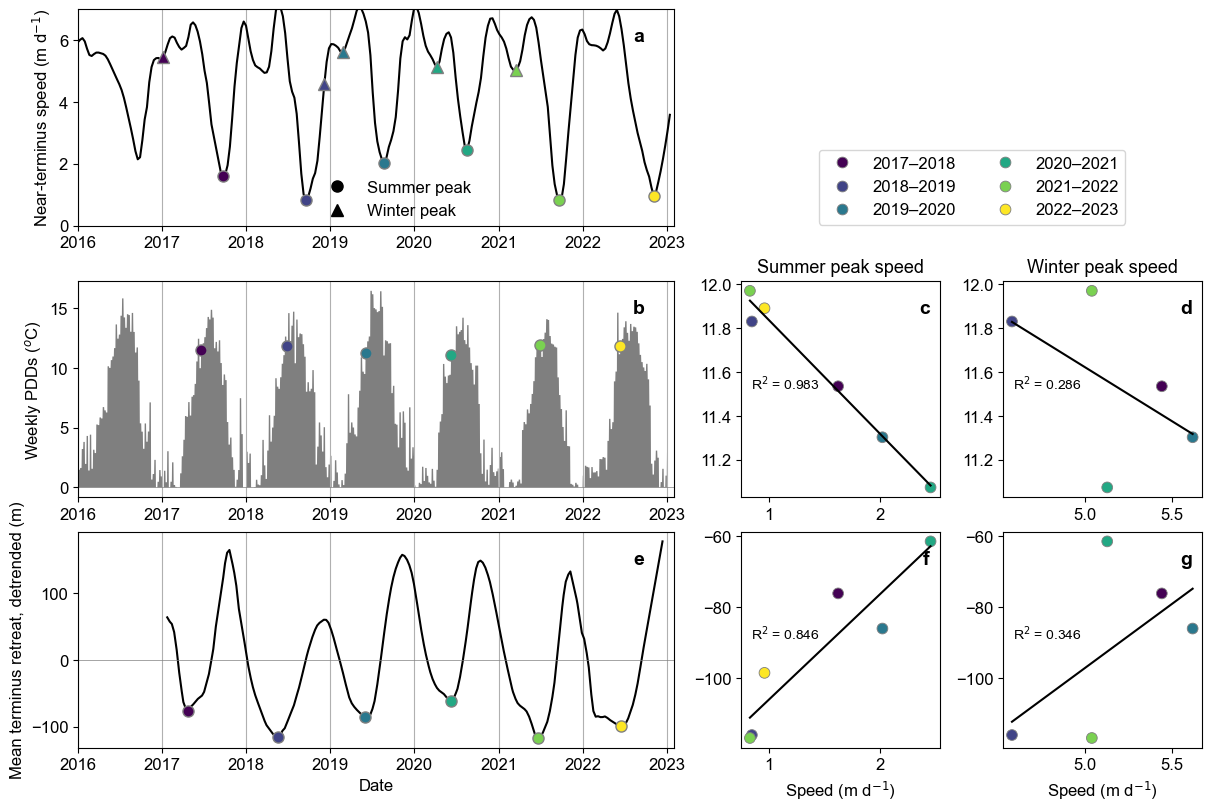

Figure saved to file: /Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/speed_peaks_vs_PDD_terminus.png


In [9]:
## Plot time series
fontsize=12
markersize=8
plt.rcParams.update({'font.sans-serif': 'Arial', 'font.size': fontsize})
fig, ax = plt.subplots(3, 3, figsize=(12,8), gridspec_kw={'width_ratios': [3,1,1]}, constrained_layout=True)

# -----Time series
# Speed
ax[0,0].plot(v_term['Date'], v_term['Mean'], '-k')
for date, summer_peak, color in v_summer_peaks[['Date', 'Mean', 'color']].values:
    ax[0,0].plot(date, summer_peak, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
for date, winter_peak, color in v_winter_peaks[['Date', 'Mean', 'color']].values:
    if date.year < 2022:
        ax[0,0].plot(date, winter_peak, '^', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
ax[0,0].plot(np.datetime64('2000-01-01'), 0, 'o', color='k', markersize=markersize, label='Summer peak')
ax[0,0].plot(np.datetime64('2000-01-01'), 0, '^', color='k', markersize=markersize, label='Winter peak')
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', frameon=False, bbox_to_anchor=[0.2, 0.6, 0.2, 0.2])
ax[0,0].set_ylim(0,7)
ax[0,0].set_ylabel('Near-terminus speed (m d$^{-1}$)')

# PDDs
ax[1,0].fill_between(air['Date'], np.zeros(len(air)), air['weekly_PDD'], 
                     facecolor='k', edgecolor=None, alpha=0.5)
for date, pdd, color in pdd_peaks[['Date', 'weekly_PDD', 'color']].values:
     ax[1,0].plot(date, pdd, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
ax[1,0].set_ylabel('Weekly PDDs ($^o$C)')

ax[2,0].plot(term['Date'], term['Mean_retreat_detrended_m'], '-k')
for date, retreat, color in term_peaks[['Date', 'Mean_retreat_detrended_m', 'color']].values:
    ax[2,0].plot(date, retreat, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
ax[2,0].set_ylabel('Mean terminus retreat, detrended (m)')
ax[2,0].set_xlabel('Date')
# adjust axes
xmin, xmax = np.datetime64('2016-01-01'), np.datetime64('2023-02-01')
for axis in ax[:,0]:
    axis.set_xlim(xmin, xmax)
    axis.xaxis.grid(True)
    axis.hlines(0, xmin, xmax, linewidth=0.5, color='grey')

# -----Peak regressions
def linear_fit(df):
    X, y = df.dropna().values[:,0], df.dropna().values[:,1]
    X = X.reshape(-1,1)
    lr = LinearRegression().fit(X,y)
    score = lr.score(X,y)
    Xpred = np.linspace(np.min(X), np.max(X), 100).reshape(-1,1)
    ypred = lr.predict(Xpred)
    return Xpred, ypred, score
def plot_score(axis, score):
    axis.text(0.05, 0.5, f'R$^2$ = {np.round(score,3)}', transform=axis.transAxes, ha='left', fontsize=fontsize-2)
    return
# PDD-summer
sns.scatterplot(data=peaks_merged, x='Mean_summer_peak', y='weekly_PDD', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', ax=ax[1,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean_summer_peak', 'weekly_PDD']])
ax[1,1].plot(Xpred, ypred, '-k')
plot_score(ax[1,1], score)
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('')
ax[1,1].set_title('Summer peak speed', fontsize=fontsize+1)
# Add legend for years
handles, labels = ax[1,1].get_legend_handles_labels()
ax[1,1].legend().remove()
labels = ['2017–2018', '2018–2019', '2019–2020', '2020–2021', '2021–2022', '2022–2023']
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=[0.74, 0.63, 0.2, 0.2], ncols=2)
# PDD-winter
sns.scatterplot(data=peaks_merged, x='Mean_winter_peak', y='weekly_PDD', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[1,2]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean_winter_peak', 'weekly_PDD']])
ax[1,2].plot(Xpred, ypred, '-k')
plot_score(ax[1,2], score)
ax[1,2].set_xlabel('')
ax[1,2].set_ylabel('')
ax[1,2].set_title('Winter peak speed', fontsize=fontsize+1)
# Term-summer
sns.scatterplot(data=peaks_merged, x='Mean_summer_peak', y='Mean_retreat_detrended_m', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[2,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean_summer_peak', 'Mean_retreat_detrended_m']])
ax[2,1].plot(Xpred, ypred, '-k')
plot_score(ax[2,1], score)
ax[2,1].set_ylabel('')
ax[2,1].set_xlabel('Speed (m d$^{-1}$)')
# Term-winter
sns.scatterplot(data=peaks_merged, x='Mean_winter_peak', y='Mean_retreat_detrended_m', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[2,2]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean_winter_peak', 'Mean_retreat_detrended_m']])
ax[2,2].plot(Xpred, ypred, '-k')
plot_score(ax[2,2], score)
ax[2,2].set_ylabel('')
ax[2,2].set_xlabel('Speed (m d$^{-1}$)')

# Add panel labels
def plot_panel_label(axis, label):
    axis.text(0.95, 0.85, label, transform=axis.transAxes,
              ha='right', fontweight='bold', fontsize=fontsize+2)
    return
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
for axis, label in list(zip([ax[0,0], 
                             ax[1,0], ax[1,1], ax[1,2],
                             ax[2,0], ax[2,1], ax[2,2]], labels)):
    plot_panel_label(axis, label)

# Remove unused axes
ax[0,1].remove()
ax[0,2].remove()

# fig.tight_layout()
plt.show()

# Save figure
fig_fn = os.path.join(out_path, 'speed_peaks_vs_PDD_terminus.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

In [10]:
## Calculate annual peaks
# Add fake year columns (starting in April)
def add_fake_year_column(df):
    def calculate_fake_year(month, year):
        if month <= 0:
            return year-1
        else:
            return year
    months, years = df['Date'].dt.month.values, df['Date'].dt.year.values
    df['fake_year'] = [calculate_fake_year(month, year) 
                        for month, year in list(zip(months, years))]
    return df
def subset_fake_years_add_color(df):
    df = df.loc[(df['fake_year'] >= 2017) & (df['fake_year'] <= 2022)]
    df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
    return df

# PDDs
air = add_fake_year_column(air)
air['fake_year'] = air['fake_year'] + 1
def calculate_pdd(temp):
    if temp > 0:
        return temp
    else:
        return 0

#cumulative PDDs
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)
# print(air)
# air['cumulative_PDD'] = air.groupby(air['Date'].dt.year)['PDD'].cumsum()
# ipeaks = air.groupby(air['fake_year'])['cumulative_PDD'].idxmax().values
# pdd_peaks = air.loc[ipeaks, ['Date', 'cumulative_PDD', 'fake_year']].reset_index(drop=True)
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

#Max PDD
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)
# ipeaks = air.groupby(air['fake_year'])['PDD'].idxmax().values
# pdd_peaks = air.loc[ipeaks, ['Date', 'cumulative_PDD', 'fake_year']].reset_index(drop=True)
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

#first weekly averaged PDD exceeding 9 

# # # Assuming air['Date'] is already a datetime object
# air['Week'] = air['Date'].dt.isocalendar().week
# air['Year'] = air['Date'].dt.year

# # Group by year and week, and calculate the weekly average
# air['fake_year'] = air['Date'].dt.year
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# air['weekly_PDD'] = air.groupby(['Year', 'Week'])['PDD'].transform('mean')
# air['time_of_weekly_PDD'] = air.groupby(['Year', 'Week'])['Date'].transform('first')

# # Optional: drop the intermediate columns if no longer needed
# air = air.drop(columns=['Week', 'Year'])

# # Create a mask where the condition weekly_PDD >= threshold is met
# mask = (air['weekly_PDD'] <= 12) & (air['Date'].dt.month <= 6) #&(air['Date'].dt.year >= 2017)

# # Group by 'fake_year' and find the first index where the threshold is met
# ipeaks = air[mask].groupby(air['fake_year'])['weekly_PDD'].idxmax().values
# ipeaks = air[mask].groupby(air['fake_year'])['weekly_PDD'].idxmax().values
# #ipeaks = air.groupby(air['fake_year'])['weekly_PDD'].idxmax().values

# pdd_peaks = air.loc[ipeaks, ['Date', 'weekly_PDD', 'fake_year']].reset_index(drop=True)
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

# timing of weekly averaged PDD exceeding threshold 

# Define year and week for grouping
# air['Week'] = air['Date'].dt.isocalendar().week
# air['Year'] = air['Date'].dt.year

# # Add a column for fake year and calculate PDD
# air['fake_year'] = air['Date'].dt.year
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# # Calculate weekly average PDD and the first date of each week
# air['weekly_PDD'] = air.groupby(['Year', 'Week'])['PDD'].transform('mean')
# air['day_of_year_PDD'] = air.groupby(['Year', 'Week'])['Date'].transform('first')
# # Convert 'time_of_weekly_PDD' to the day of the year
# air['day_of_year_PDD'] = air['day_of_year_PDD'].dt.dayofyear

# # Optional: drop intermediate columns
# air = air.drop(columns=['Week', 'Year'])

# # Create a mask to filter for weeks meeting the threshold within the first six months
# mask = (air['weekly_PDD'] >= 4) & (air['Date'].dt.month <= 7)

# # Find the first occurrence in each fake_year where the threshold is met
# pdd_peaks = (
#     air[mask]
#     .groupby('fake_year')
#     .apply(lambda x: x.loc[x['Date'].idxmin()])
#     .reset_index(drop=True)
# )

# # # Find the time when the max weekly PDD is reached within each fake_year
# # pdd_peaks = (
# #     air.groupby('fake_year')
# #     .apply(lambda x: x.loc[x['weekly_PDD'].idxmax()])
# #     .reset_index(drop=True)
# # )

# # Add color with the subset_fake_years_add_color function
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

# timing of biweekly 
         
# Assuming 'air' DataFrame is already defined and 'calculate_pdd' function is available

# Define year and biweek for grouping
air['Biweek'] = ((air['Date'].dt.isocalendar().week - 1) // 2) + 1  # Grouping into biweekly intervals
air['Year'] = air['Date'].dt.year

# Add a column for fake year and calculate PDD
air['fake_year'] = air['Date'].dt.year
air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# Calculate biweekly average PDD and the first date of each biweek
air['biweekly_PDD'] = air.groupby(['Year', 'Biweek'])['PDD'].transform('mean')
air['day_of_year_PDD'] = air.groupby(['Year', 'Biweek'])['Date'].transform('first')

# Convert 'day_of_year_PDD' to the day of the year
air['day_of_year_PDD'] = air['day_of_year_PDD'].dt.dayofyear

# Optional: drop intermediate columns
air = air.drop(columns=['Biweek', 'Year'])

# Create a mask to filter for biweeks meeting the threshold within the first six months
mask = (air['biweekly_PDD'] >= 4) & (air['Date'].dt.month <= 7)

# Find the first occurrence in each fake_year where the threshold is met
pdd_peaks = (
    air[mask]
    .groupby('fake_year')
    .apply(lambda x: x.loc[x['Date'].idxmin()])
    .reset_index(drop=True)
)

# Add color with the subset_fake_years_add_color function
pdd_peaks = subset_fake_years_add_color(pdd_peaks)
 
# cumulative sum pdd 

# # Add a column for fake year and calculate PDD
# air['fake_year'] = air['Date'].dt.year
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# # Calculate cumulative PDD
# air['cumulative_PDD'] = air.groupby('fake_year')['PDD'].cumsum()

# # Define your cumulative threshold
# cumulative_threshold = 150  # Set your desired threshold value

# # Create a mask to find where cumulative PDD meets the threshold
# cumulative_mask = (air['cumulative_PDD'] >= cumulative_threshold)

# # Find the first occurrence in each fake_year where the cumulative PDD reaches the threshold
# ipeaks_cumulative = air[cumulative_mask].groupby('fake_year').first().reset_index()

# # Add the day of the year for each peak
# ipeaks_cumulative['day_of_year_PDD'] = ipeaks_cumulative['Date'].dt.dayofyear

# # Select relevant columns for output
# pdd_peaks = ipeaks_cumulative[['fake_year', 'Date', 'day_of_year_PDD', 'cumulative_PDD']].reset_index(drop=True)

# # Optionally, add color with the subset_fake_years_add_color function
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

# Terminus retreat
term = add_fake_year_column(term)
ipeaks = term.groupby(term['Date'].dt.year)['Mean_retreat_detrended_m'].idxmax()
term_peaks = term.loc[ipeaks, ['Date', 'Mean_retreat_detrended_m', 'fake_year']].reset_index(drop=True)
term_peaks = subset_fake_years_add_color(term_peaks)

# term = add_fake_year_column(term)
# v_term = add_fake_year_column(v_term)

# Find indices for the maximum retreat and minimum advance
# ipeaks_retreat = term.groupby(term['Date'].dt.year)['Mean_retreat_detrended_m'].idxmax()
# ipeaks_advance = term.groupby(term['Date'].dt.year)['Mean_retreat_detrended_m'].idxmin()

# retreat_peaks = term.loc[ipeaks_retreat, ['Date', 'Mean_retreat_detrended_m', 'fake_year']].reset_index(drop=True)
# retreat_peaks['Peak_Type'] = 'Max Retreat'

#advance_peaks = term.loc[ipeaks_advance, ['Date', 'Mean_retreat_detrended_m', 'fake_year']].reset_index(drop=True)
#advance_peaks['Peak_Type'] = 'Min Advance'

# term_peaks = pd.concat([retreat_peaks, advance_peaks], ignore_index=True)

# Add color with the subset_fake_years_add_color function
# term_peaks = subset_fake_years_add_color(term_peaks)

# Speed minimums
v_term = add_fake_year_column(v_term)
imins = v_term.groupby('fake_year')['Mean'].idxmin().values
v_mins = v_term.loc[imins, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
v_mins = subset_fake_years_add_color(v_mins)

### Summer speed peaks

#summer max
#v_term_summer = v_term.loc[(v_term['Date'].dt.month >= 4) & ((v_term['Date'].dt.month <= 6))]
#ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['Mean'].idxmax().values
# v_summer_peaks = v_term_summer.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
# v_summer_peaks = subset_fake_years_add_color(v_summer_peaks)

#summer min 
# v_term_summer = v_term.loc[(v_term['Date'].dt.month >= 6) & ((v_term['Date'].dt.month <= 11))]
# ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['Mean'].idxmin().values
# v_summer_peaks = v_term_summer.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
# v_summer_peaks = subset_fake_years_add_color(v_summer_peaks)

# min between winter and summer
v_term_summer = v_term.loc[(v_term['Date'].dt.month >= 2) & ((v_term['Date'].dt.month <= 5))]
ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['Mean'].idxmin().values

# Extract the day of the year instead of the actual date for each minimum velocity
v_summer_peaks = v_term_summer.loc[ipeaks].reset_index(drop=True)
v_summer_peaks['day_of_year_vsum'] = v_summer_peaks['Date'].dt.dayofyear

# Drop the original 'Date' column if you only need the day of the year
v_summer_peaks = v_summer_peaks[['day_of_year_vsum', 'Date', 'Mean', 'fake_year']]

# Optionally, add color or additional processing with the subset_fake_years_add_color function
v_summer_peaks = subset_fake_years_add_color(v_summer_peaks)

# Winter speed peaks
v_term_winter = v_term.loc[(v_term['Date'].dt.month > 10) | ((v_term['Date'].dt.month < 1))]
ipeaks = v_term_winter.groupby(v_term_winter['fake_year'])['Mean'].idxmax().values

# Winter speed min
#v_term_winter['Year'] = v_term_winter['Date'].dt.year
#v_term_winter = v_term.loc[(v_term['Date'].dt.month >= 12) | ((v_term['Date'].dt.month <= 5))]
#ipeaks = v_term_winter.groupby(v_term_winter['fake_year'])['Mean'].idxmin().values

v_winter_peaks = v_term_winter.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
v_winter_peaks = subset_fake_years_add_color(v_winter_peaks)

# Subtract minimum velocities from winter and summer peaks
# v_summer_peaks['Mean'] -= v_mins['Mean']
# v_winter_peaks['Mean'] -= v_mins['Mean']

# Merge into one dataframe for regression plotting
peaks_merged = (pdd_peaks[['fake_year', 'color', 'day_of_year_PDD', 'biweekly_PDD']].merge(
    term_peaks[['fake_year', 'Mean_retreat_detrended_m']].merge(
        v_summer_peaks[['fake_year', 'Mean', 'day_of_year_vsum']].merge(
            v_winter_peaks[['fake_year', 'Mean']], on='fake_year', how='outer', suffixes=['_summer_peak', '_winter_peak']),
        on='fake_year', how='outer'),
    on='fake_year', how='outer'))

# Set winter 2022 observations to NaN (probably not capturing true peaks)
peaks_merged.loc[peaks_merged['fake_year']==2022, ['Mean_winter_peak']] = np.nan
peaks_merged

/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_4132/3646674793.py:137: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x['Date'].idxmin()])
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_4132/3646674793.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_4132/3646674793.py:15: SettingWithCopyWarnin

,fake_year,color,day_of_year_PDD,biweekly_PDD,Mean_retreat_detrended_m,Mean_summer_peak,day_of_year_vsum,Mean_winter_peak
0,2017,"(0.267004, 0.004874, 0.329415, 1.0)",100,5.951919,165.108281,5.696602,85,6.605157
1,2018,"(0.253935, 0.265254, 0.529983, 1.0)",99,4.944168,60.540930,4.943701,80,5.738079
2,2019,"(0.163625, 0.471133, 0.558148, 1.0)",70,5.757740,157.846567,5.618402,55,7.047702
3,2020,"(0.134692, 0.658636, 0.517649, 1.0)",111,5.833389,149.112626,5.129589,100,6.710538
4,2021,"(0.477504, 0.821444, 0.318195, 1.0)",102,5.145728,132.872476,5.041533,74,6.344725
5,2022,"(0.993248, 0.906157, 0.143936, 1.0)",115,5.319648,177.977022,5.668544,89,NaN


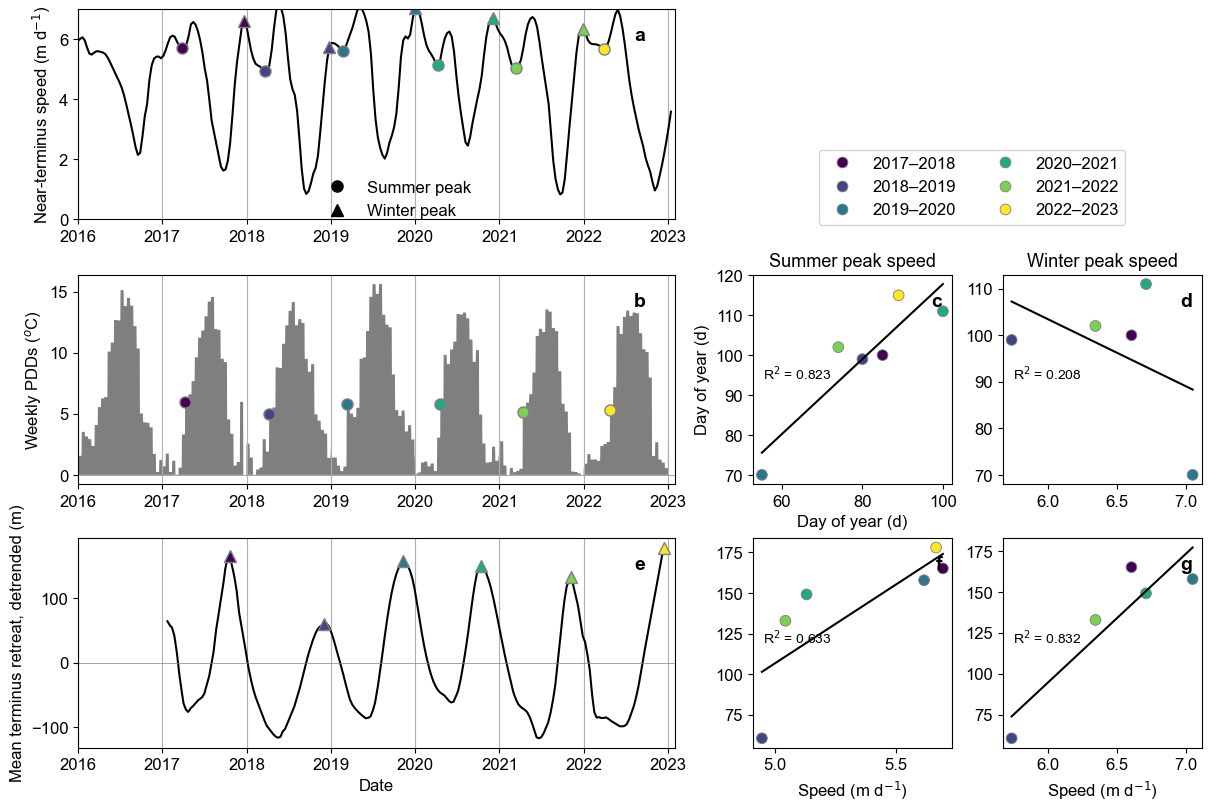

Figure saved to file: /Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/speed_peaks_vs_PDD_terminus.png


In [11]:
## Plot time series
fontsize=12
markersize=8
plt.rcParams.update({'font.sans-serif': 'Arial', 'font.size': fontsize})
fig, ax = plt.subplots(3, 3, figsize=(12,8), gridspec_kw={'width_ratios': [3,1,1]}, constrained_layout=True)

# -----Time series
# Speed
ax[0,0].plot(v_term['Date'], v_term['Mean'], '-k')
for date, summer_peak, color in v_summer_peaks[['Date', 'Mean', 'color']].values:
    ax[0,0].plot(date, summer_peak, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
for date, winter_peak, color in v_winter_peaks[['Date', 'Mean', 'color']].values:
    if date.year < 2022:
        ax[0,0].plot(date, winter_peak, '^', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
ax[0,0].plot(np.datetime64('2000-01-01'), 0, 'o', color='k', markersize=markersize, label='Summer peak')
ax[0,0].plot(np.datetime64('2000-01-01'), 0, '^', color='k', markersize=markersize, label='Winter peak')
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', frameon=False, bbox_to_anchor=[0.2, 0.6, 0.2, 0.2])
ax[0,0].set_ylim(0,7)
ax[0,0].set_ylabel('Near-terminus speed (m d$^{-1}$)')

# PDDs
#weekly PDD
ax[1,0].fill_between(air['Date'], np.zeros(len(air)), air['biweekly_PDD'], 
                     facecolor='k', edgecolor=None, alpha=0.5)
for date, pdd, color in pdd_peaks[['Date', 'biweekly_PDD', 'color']].values:
     ax[1,0].plot(date, pdd, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
ax[1,0].set_ylabel('Weekly PDDs ($^o$C)')

# cumulative PDD
# ax[1,0].fill_between(air['Date'], np.zeros(len(air)), air['cumulative_PDD'], 
#                      facecolor='k', edgecolor=None, alpha=0.5)
# for date, pdd, color in pdd_peaks[['Date', 'cumulative_PDD', 'color']].values:
#      ax[1,0].plot(date, pdd, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
# ax[1,0].set_ylabel('Cumulative PDDs ($^o$C)')

ax[2,0].plot(term['Date'], term['Mean_retreat_detrended_m'], '-k')
for date, retreat, color in term_peaks[['Date', 'Mean_retreat_detrended_m', 'color']].values:
    ax[2,0].plot(date, retreat, '^', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
# for index, row in term_peaks.iterrows():
#     if row['Peak_Type'] == 'Max Retreat':
#         ax[2, 0].plot(row['Date'], row['Mean_retreat_detrended_m'], 'o', 
#                       markerfacecolor=row['color'],  # Use the color from the row
#                       markeredgecolor='gray', 
#                       linewidth=0.5, markersize=markersize, 
#                       label='Retreat Peaks' if index == 0 else "")
#     elif row['Peak_Type'] == 'Min Advance':
#         ax[2, 0].plot(row['Date'], row['Mean_retreat_detrended_m'], '^', 
#                       markerfacecolor=row['color'],  # Use the color from the row
#                       markeredgecolor='gray', 
#                       linewidth=0.5, markersize=markersize, 
#                       label='Advance Peaks' if index == 0 else "")
        
ax[2,0].set_ylabel('Mean terminus retreat, detrended (m)')
ax[2,0].set_xlabel('Date')
# adjust axes
xmin, xmax = np.datetime64('2016-01-01'), np.datetime64('2023-02-01')
for axis in ax[:,0]:
    axis.set_xlim(xmin, xmax)
    axis.xaxis.grid(True)
    axis.hlines(0, xmin, xmax, linewidth=0.5, color='grey')

# -----Peak regressions
def linear_fit(df):
    X, y = df.dropna().values[:,0], df.dropna().values[:,1]
    X = X.reshape(-1,1)
    lr = LinearRegression().fit(X,y)
    score = lr.score(X,y)
    Xpred = np.linspace(np.min(X), np.max(X), 100).reshape(-1,1)
    ypred = lr.predict(Xpred)
    return Xpred, ypred, score
def plot_score(axis, score):
    axis.text(0.05, 0.5, f'R$^2$ = {np.round(score,3)}', transform=axis.transAxes, ha='left', fontsize=fontsize-2)
    return
# PDD-summer
sns.scatterplot(data=peaks_merged, x='day_of_year_vsum', y='day_of_year_PDD', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', ax=ax[1,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['day_of_year_vsum', 'day_of_year_PDD']])
ax[1,1].plot(Xpred, ypred, '-k')
plot_score(ax[1,1], score)
ax[1,1].set_xlabel('Day of year (d)')
ax[1,1].set_ylabel('Day of year (d)')
ax[1,1].set_title('Summer peak speed', fontsize=fontsize+1)
# Add legend for years
handles, labels = ax[1,1].get_legend_handles_labels()
ax[1,1].legend().remove()
labels = ['2017–2018', '2018–2019', '2019–2020', '2020–2021', '2021–2022', '2022–2023']
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=[0.74, 0.63, 0.2, 0.2], ncols=2)
# PDD-winter
sns.scatterplot(data=peaks_merged, x='Mean_winter_peak', y='day_of_year_PDD', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[1,2]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean_winter_peak', 'day_of_year_PDD']])
ax[1,2].plot(Xpred, ypred, '-k')
plot_score(ax[1,2], score)
ax[1,2].set_xlabel('')
ax[1,2].set_ylabel('')
ax[1,2].set_title('Winter peak speed', fontsize=fontsize+1)
# Term-summer
sns.scatterplot(data=peaks_merged, x='Mean_summer_peak', y='Mean_retreat_detrended_m', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[2,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean_summer_peak', 'Mean_retreat_detrended_m']])
ax[2,1].plot(Xpred, ypred, '-k')
plot_score(ax[2,1], score)
ax[2,1].set_ylabel('')
ax[2,1].set_xlabel('Speed (m d$^{-1}$)')
# Term-winter
sns.scatterplot(data=peaks_merged, x='Mean_winter_peak', y='Mean_retreat_detrended_m', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[2,2]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean_winter_peak', 'Mean_retreat_detrended_m']])
ax[2,2].plot(Xpred, ypred, '-k')
plot_score(ax[2,2], score)
ax[2,2].set_ylabel('')
ax[2,2].set_xlabel('Speed (m d$^{-1}$)')

# Add panel labels
def plot_panel_label(axis, label):
    axis.text(0.95, 0.85, label, transform=axis.transAxes,
              ha='right', fontweight='bold', fontsize=fontsize+2)
    return
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
for axis, label in list(zip([ax[0,0], 
                             ax[1,0], ax[1,1], ax[1,2],
                             ax[2,0], ax[2,1], ax[2,2]], labels)):
    plot_panel_label(axis, label)

# Remove unused axes
ax[0,1].remove()
ax[0,2].remove()

# fig.tight_layout()
plt.show()

# Save figure
fig_fn = os.path.join(out_path, 'speed_peaks_vs_PDD_terminus.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

In [12]:
## Calculate annual peaks
# Add fake year columns (starting in April)
def add_fake_year_column(df):
    def calculate_fake_year(month, year):
        if month <= 0:
            return year-1
        else:
            return year
    months, years = df['Date'].dt.month.values, df['Date'].dt.year.values
    df['fake_year'] = [calculate_fake_year(month, year) 
                        for month, year in list(zip(months, years))]
    return df
def subset_fake_years_add_color(df):
    df = df.loc[(df['fake_year'] >= 2017) & (df['fake_year'] <= 2022)]
    df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
    return df

# PDDs
air = add_fake_year_column(air)
air['fake_year'] = air['fake_year'] + 1
def calculate_pdd(temp):
    if temp > 0:
        return temp
    else:
        return 0

#cumulative PDDs
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)
# print(air)
# air['cumulative_PDD'] = air.groupby(air['Date'].dt.year)['PDD'].cumsum()
# ipeaks = air.groupby(air['fake_year'])['cumulative_PDD'].idxmax().values
# pdd_peaks = air.loc[ipeaks, ['Date', 'cumulative_PDD', 'fake_year']].reset_index(drop=True)
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

#Max PDD
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)
# ipeaks = air.groupby(air['fake_year'])['PDD'].idxmax().values
# pdd_peaks = air.loc[ipeaks, ['Date', 'cumulative_PDD', 'fake_year']].reset_index(drop=True)
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

#first weekly averaged PDD exceeding 9 

# # # Assuming air['Date'] is already a datetime object
# air['Week'] = air['Date'].dt.isocalendar().week
# air['Year'] = air['Date'].dt.year

# # Group by year and week, and calculate the weekly average
# air['fake_year'] = air['Date'].dt.year
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# air['weekly_PDD'] = air.groupby(['Year', 'Week'])['PDD'].transform('mean')
# air['time_of_weekly_PDD'] = air.groupby(['Year', 'Week'])['Date'].transform('first')

# # Optional: drop the intermediate columns if no longer needed
# air = air.drop(columns=['Week', 'Year'])

# # Create a mask where the condition weekly_PDD >= threshold is met
# mask = (air['weekly_PDD'] <= 12) & (air['Date'].dt.month <= 6) #&(air['Date'].dt.year >= 2017)

# # Group by 'fake_year' and find the first index where the threshold is met
# ipeaks = air[mask].groupby(air['fake_year'])['weekly_PDD'].idxmax().values
# ipeaks = air[mask].groupby(air['fake_year'])['weekly_PDD'].idxmax().values
# #ipeaks = air.groupby(air['fake_year'])['weekly_PDD'].idxmax().values

# pdd_peaks = air.loc[ipeaks, ['Date', 'weekly_PDD', 'fake_year']].reset_index(drop=True)
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

# timing of weekly averaged PDD exceeding threshold 

# Define year and week for grouping
# air['Week'] = air['Date'].dt.isocalendar().week
# air['Year'] = air['Date'].dt.year

# # Add a column for fake year and calculate PDD
# air['fake_year'] = air['Date'].dt.year
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# # Calculate weekly average PDD and the first date of each week
# air['weekly_PDD'] = air.groupby(['Year', 'Week'])['PDD'].transform('mean')
# air['day_of_year_PDD'] = air.groupby(['Year', 'Week'])['Date'].transform('first')
# # Convert 'time_of_weekly_PDD' to the day of the year
# air['day_of_year_PDD'] = air['day_of_year_PDD'].dt.dayofyear

# # Optional: drop intermediate columns
# air = air.drop(columns=['Week', 'Year'])

# # Create a mask to filter for weeks meeting the threshold within the first six months
# mask = (air['weekly_PDD'] >= 4) & (air['Date'].dt.month <= 7)

# # Find the first occurrence in each fake_year where the threshold is met
# pdd_peaks = (
#     air[mask]
#     .groupby('fake_year')
#     .apply(lambda x: x.loc[x['Date'].idxmin()])
#     .reset_index(drop=True)
# )

# # # Find the time when the max weekly PDD is reached within each fake_year
# # pdd_peaks = (
# #     air.groupby('fake_year')
# #     .apply(lambda x: x.loc[x['weekly_PDD'].idxmax()])
# #     .reset_index(drop=True)
# # )

# # Add color with the subset_fake_years_add_color function
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

# timing of biweekly 
         
# Assuming 'air' DataFrame is already defined and 'calculate_pdd' function is available

# Define year and biweek for grouping
air['Biweek'] = ((air['Date'].dt.isocalendar().week - 1) // 2) + 1  # Grouping into biweekly intervals
air['Year'] = air['Date'].dt.year

# Add a column for fake year and calculate PDD
air['fake_year'] = air['Date'].dt.year
air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# Calculate biweekly average PDD and the first date of each biweek
air['biweekly_PDD'] = air.groupby(['Year', 'Biweek'])['PDD'].transform('mean')
air['day_of_year_PDD'] = air.groupby(['Year', 'Biweek'])['Date'].transform('first')

# Convert 'day_of_year_PDD' to the day of the year
air['day_of_year_PDD'] = air['day_of_year_PDD'].dt.dayofyear

# Optional: drop intermediate columns
air = air.drop(columns=['Biweek', 'Year'])

# Create a mask to filter for biweeks meeting the threshold within the first six months
mask = (air['biweekly_PDD'] >= 4) & (air['Date'].dt.month <= 7)

# Find the first occurrence in each fake_year where the threshold is met
pdd_peaks = (
    air[mask]
    .groupby('fake_year')
    .apply(lambda x: x.loc[x['Date'].idxmin()])
    .reset_index(drop=True)
)

# Add color with the subset_fake_years_add_color function
pdd_peaks = subset_fake_years_add_color(pdd_peaks)
 
# cumulative sum pdd 

# # Add a column for fake year and calculate PDD
# air['fake_year'] = air['Date'].dt.year
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# # Calculate cumulative PDD
# air['cumulative_PDD'] = air.groupby('fake_year')['PDD'].cumsum()

# # Define your cumulative threshold
# cumulative_threshold = 150  # Set your desired threshold value

# # Create a mask to find where cumulative PDD meets the threshold
# cumulative_mask = (air['cumulative_PDD'] >= cumulative_threshold)

# # Find the first occurrence in each fake_year where the cumulative PDD reaches the threshold
# ipeaks_cumulative = air[cumulative_mask].groupby('fake_year').first().reset_index()

# # Add the day of the year for each peak
# ipeaks_cumulative['day_of_year_PDD'] = ipeaks_cumulative['Date'].dt.dayofyear

# # Select relevant columns for output
# pdd_peaks = ipeaks_cumulative[['fake_year', 'Date', 'day_of_year_PDD', 'cumulative_PDD']].reset_index(drop=True)

# # Optionally, add color with the subset_fake_years_add_color function
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

# Max Terminus retreat
# term = add_fake_year_column(term)
# ipeaks = term.groupby(term['Date'].dt.year)['Mean_retreat_detrended_m'].idxmax()
# term_peaks = term.loc[ipeaks, ['Date', 'Mean_retreat_detrended_m', 'fake_year']].reset_index(drop=True)
# term_peaks = subset_fake_years_add_color(term_peaks)

# Max terminus advance
term = add_fake_year_column(term)
ipeaks = term.groupby(term['Date'].dt.year)['Mean_retreat_detrended_m'].idxmin()
term_peaks = term.loc[ipeaks, ['Date', 'Mean_retreat_detrended_m', 'fake_year']].reset_index(drop=True)
term_peaks = subset_fake_years_add_color(term_peaks)

# term = add_fake_year_column(term)
# v_term = add_fake_year_column(v_term)

# Find indices for the maximum retreat and minimum advance
# ipeaks_retreat = term.groupby(term['Date'].dt.year)['Mean_retreat_detrended_m'].idxmax()
# ipeaks_advance = term.groupby(term['Date'].dt.year)['Mean_retreat_detrended_m'].idxmin()

# retreat_peaks = term.loc[ipeaks_retreat, ['Date', 'Mean_retreat_detrended_m', 'fake_year']].reset_index(drop=True)
# retreat_peaks['Peak_Type'] = 'Max Retreat'

#advance_peaks = term.loc[ipeaks_advance, ['Date', 'Mean_retreat_detrended_m', 'fake_year']].reset_index(drop=True)
#advance_peaks['Peak_Type'] = 'Min Advance'

# term_peaks = pd.concat([retreat_peaks, advance_peaks], ignore_index=True)

# Add color with the subset_fake_years_add_color function
# term_peaks = subset_fake_years_add_color(term_peaks)


# Speed minimums
v_term = add_fake_year_column(v_term)
imins = v_term.groupby('fake_year')['Mean'].idxmin().values
v_mins = v_term.loc[imins, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
# Add day of the year for each peak based on the 'Date' column
v_mins['day_of_year_vmin'] = term_peaks['Date'].dt.dayofyear

v_mins = subset_fake_years_add_color(v_mins)

### Summer speed peaks

#summer max
#v_term_summer = v_term.loc[(v_term['Date'].dt.month >= 4) & ((v_term['Date'].dt.month <= 6))]
#ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['Mean'].idxmax().values
# v_summer_peaks = v_term_summer.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
# v_summer_peaks = subset_fake_years_add_color(v_summer_peaks)

#summer min 
# v_term_summer = v_term.loc[(v_term['Date'].dt.month >= 6) & ((v_term['Date'].dt.month <= 11))]
# ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['Mean'].idxmin().values
# v_summer_peaks = v_term_summer.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
# v_summer_peaks = subset_fake_years_add_color(v_summer_peaks)

# min between winter and summer
v_term_summer = v_term.loc[(v_term['Date'].dt.month >= 2) & ((v_term['Date'].dt.month <= 5))]
ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['Mean'].idxmin().values

# Extract the day of the year instead of the actual date for each minimum velocity
v_summer_peaks = v_term_summer.loc[ipeaks].reset_index(drop=True)
v_summer_peaks['day_of_year_vsum'] = v_summer_peaks['Date'].dt.dayofyear

# Drop the original 'Date' column if you only need the day of the year
v_summer_peaks = v_summer_peaks[['day_of_year_vsum', 'Date', 'Mean', 'fake_year']]

# Optionally, add color or additional processing with the subset_fake_years_add_color function
v_summer_peaks = subset_fake_years_add_color(v_summer_peaks)

# Winter speed peaks
#v_term_winter = v_term.loc[(v_term['Date'].dt.month > 10) | ((v_term['Date'].dt.month < 1))]
#ipeaks = v_term_winter.groupby(v_term_winter['fake_year'])['Mean'].idxmax().values

# Winter speed min
v_term_winter['Year'] = v_term_winter['Date'].dt.year
v_term_winter = v_term.loc[(v_term['Date'].dt.month >= 12) | ((v_term['Date'].dt.month <= 5))]
ipeaks = v_term_winter.groupby(v_term_winter['fake_year'])['Mean'].idxmin().values

v_winter_peaks = v_term_winter.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
v_winter_peaks = subset_fake_years_add_color(v_winter_peaks)


# Merge into one dataframe for regression plotting
peaks_merged = (v_mins[['fake_year', 'color', 'Mean', 'day_of_year_vmin']].merge(
    pdd_peaks[['fake_year', 'color', 'day_of_year_PDD', 'biweekly_PDD']].merge(
    term_peaks[['fake_year', 'Mean_retreat_detrended_m']].merge(
        v_summer_peaks[['fake_year', 'Mean', 'day_of_year_vsum']].merge(
            v_winter_peaks[['fake_year', 'Mean']], on='fake_year', how='outer', suffixes=['_summer_peak', '_winter_peak']),
        on='fake_year', how='outer'),
    on='fake_year', how='outer')))

# Set winter 2022 observations to NaN (probably not capturing true peaks)
peaks_merged.loc[peaks_merged['fake_year']==2022, ['Mean_winter_peak']] = np.nan
peaks_merged

/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_4132/1400564668.py:137: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x['Date'].idxmin()])
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_4132/1400564668.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_4132/1400564668.py:15: SettingWithCopyWarnin

,fake_year,color,Mean,day_of_year_vmin,day_of_year_PDD,biweekly_PDD,Mean_retreat_detrended_m,Mean_summer_peak,day_of_year_vsum,Mean_winter_peak
0,2017,"(0.267004, 0.004874, 0.329415, 1.0)",1.620097,158.0,100,5.951919,-76.076786,5.696602,85,5.442003
1,2018,"(0.253935, 0.265254, 0.529983, 1.0)",0.843316,172.0,99,4.944168,-115.957039,4.943701,80,4.584499
2,2019,"(0.163625, 0.471133, 0.558148, 1.0)",2.018903,167.0,70,5.757740,-85.971380,5.618402,55,5.618402
3,2020,"(0.134692, 0.658636, 0.517649, 1.0)",2.452430,NaN,111,5.833389,-61.430310,5.129589,100,5.129589
4,2021,"(0.477504, 0.821444, 0.318195, 1.0)",0.825701,NaN,102,5.145728,-116.793720,5.041533,74,5.041533
5,2022,"(0.993248, 0.906157, 0.143936, 1.0)",0.956983,NaN,115,5.319648,-98.453735,5.668544,89,NaN


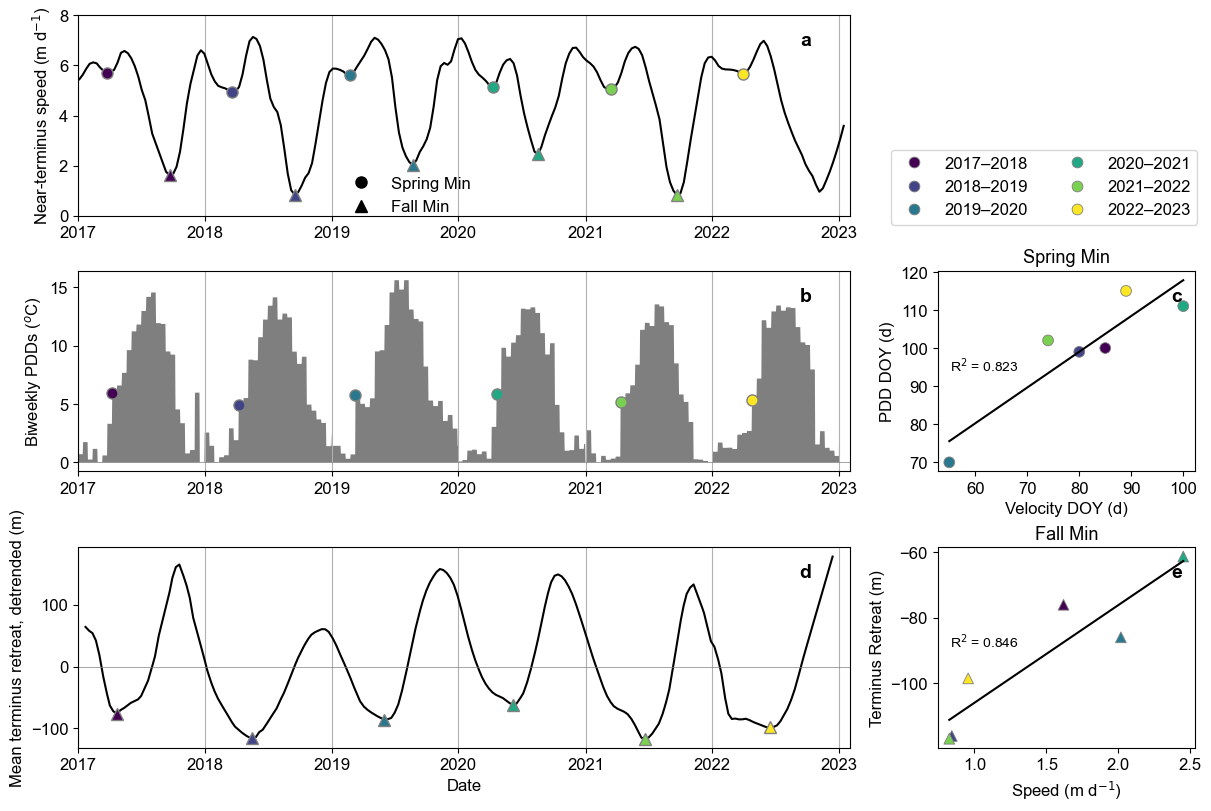

Figure saved to file: /Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/speed_peaks_vs_PDD_terminus.png


In [15]:
## Plot time series
fontsize=12
markersize=8
plt.rcParams.update({'font.sans-serif': 'Arial', 'font.size': fontsize})
fig, ax = plt.subplots(3, 2, figsize=(12,8), gridspec_kw={'width_ratios': [3,1]}, constrained_layout=True)

# -----Time series
# Speed
ax[0,0].plot(v_term['Date'], v_term['Mean'], '-k')
for date, summer_peak, color in v_summer_peaks[['Date', 'Mean', 'color']].values:
    ax[0,0].plot(date, summer_peak, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
for date, min, color in v_mins[['Date', 'Mean', 'color']].values:
    if date.year < 2022:
        ax[0,0].plot(date, min, '^', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
# ax[0,0].plot(np.datetime64('2000-01-01'), 0, 'o', color='k', markersize=markersize, label='Summer peak')
# ax[0,0].plot(np.datetime64('2000-01-01'), 0, '^', color='k', markersize=markersize, label='Winter peak')
ax[0,0].plot(np.datetime64('2000-01-01'), 0, 'o', color='k', markersize=markersize, label='Spring Min')
ax[0,0].plot(np.datetime64('2000-01-01'), 0, '^', color='k', markersize=markersize, label='Fall Min')
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', frameon=False, bbox_to_anchor=[0.2, 0.605, 0.2, 0.2])
ax[0,0].set_ylim(0,8)
ax[0,0].set_ylabel('Near-terminus speed (m d$^{-1}$)')


#PDD
ax[1,0].fill_between(air['Date'], np.zeros(len(air)), air['biweekly_PDD'], 
                     facecolor='k', edgecolor=None, alpha=0.5)
for date, pdd, color in pdd_peaks[['Date', 'biweekly_PDD', 'color']].values:
     ax[1,0].plot(date, pdd, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
ax[1,0].set_ylabel('Biweekly PDDs ($^o$C)')


ax[2,0].plot(term['Date'], term['Mean_retreat_detrended_m'], '-k')
for date, retreat, color in term_peaks[['Date', 'Mean_retreat_detrended_m', 'color']].values:
    ax[2,0].plot(date, retreat, '^', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
     
ax[2,0].set_ylabel('Mean terminus retreat, detrended (m)')
ax[2,0].set_xlabel('Date')
# adjust axes
xmin, xmax = np.datetime64('2017-01-01'), np.datetime64('2023-02-01')
for axis in ax[:,0]:
    axis.set_xlim(xmin, xmax)
    axis.xaxis.grid(True)
    axis.hlines(0, xmin, xmax, linewidth=0.5, color='grey')

# -----Peak regressions
def linear_fit(df):
    X, y = df.dropna().values[:,0], df.dropna().values[:,1]
    X = X.reshape(-1,1)
    lr = LinearRegression().fit(X,y)
    score = lr.score(X,y)
    Xpred = np.linspace(np.min(X), np.max(X), 100).reshape(-1,1)
    ypred = lr.predict(Xpred)
    return Xpred, ypred, score
def plot_score(axis, score):
    axis.text(0.05, 0.5, f'R$^2$ = {np.round(score,3)}', transform=axis.transAxes, ha='left', fontsize=fontsize-2)
    return
    
# PDD-Spring
sns.scatterplot(data=peaks_merged, x='day_of_year_vsum', y='day_of_year_PDD', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', ax=ax[1,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['day_of_year_vsum', 'day_of_year_PDD']])
ax[1,1].plot(Xpred, ypred, '-k')
plot_score(ax[1,1], score)
# ax[1,1].set_xlabel('Day of year (d)')
# ax[1,1].set_ylabel('Day of year (d)')
ax[1,1].set_xlabel('Velocity DOY (d)')
ax[1,1].set_ylabel('PDD DOY (d)')

ax[1,1].set_title('Spring Min', fontsize=fontsize+1)

# Add legend for years
handles, labels = ax[1,1].get_legend_handles_labels()
ax[1,1].legend().remove()
labels = ['2017–2018', '2018–2019', '2019–2020', '2020–2021', '2021–2022', '2022–2023']
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=[0.7, 0.63, 0.3, 0.2], ncols=2)

# # PDD-Fall
# sns.scatterplot(data=peaks_merged, x='day_of_year_vmin', y='day_of_year_PDD', hue='fake_year', 
#                 palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[1,2]) 
# Xpred, ypred, score = linear_fit(peaks_merged[['day_of_year_vmin', 'day_of_year_PDD']])
# ax[1,2].plot(Xpred, ypred, '-k')
# plot_score(ax[1,2], score)
# ax[1,2].set_xlabel('')
# ax[1,2].set_ylabel('')
# ax[1,2].set_xlabel('Velocity DOY (d)')
# ax[1,2].set_ylabel('PDD DOY (d)')

# Terminus - Fall
sns.scatterplot(data=peaks_merged, x='Mean', y='Mean_retreat_detrended_m', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), marker = '^', s=60, edgecolor='gray', legend=False, ax=ax[2,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean', 'Mean_retreat_detrended_m']])
ax[2,1].plot(Xpred, ypred, '-k')
plot_score(ax[2,1], score)
ax[2,1].set_ylabel('Terminus Retreat (m)')
ax[2,1].set_xlabel('Speed (m d$^{-1}$)')
ax[2,1].set_title('Fall Min', fontsize=fontsize+1)

# # Terminus - Spring
# sns.scatterplot(data=peaks_merged, x='Mean_summer_peak', y='Mean_retreat_detrended_m', hue='fake_year', 
#                 palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[2,1]) 
# Xpred, ypred, score = linear_fit(peaks_merged[['Mean_summer_peak', 'Mean_retreat_detrended_m']])
# ax[2,1].plot(Xpred, ypred, '-k')
# plot_score(ax[2,1], score)
# ax[2,1].set_ylabel('')
# ax[2,1].set_xlabel('Speed (m d$^{-1}$)')

# Add panel labels
def plot_panel_label(axis, label):
    axis.text(0.95, 0.85, label, transform=axis.transAxes,
              ha='right', fontweight='bold', fontsize=fontsize+2)
    return
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
for axis, label in list(zip([ax[0,0], 
                             ax[1,0], ax[1,1],
                             ax[2,0], ax[2,1]], labels)):
    plot_panel_label(axis, label)

# Remove unused axes
ax[0,1].remove()

# fig.tight_layout()
plt.show()

# Save figure
fig_fn = os.path.join(out_path, 'speed_peaks_vs_PDD_terminus.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

In [14]:
## Calculate annual peaks
# Add fake year columns (starting in April)
def add_fake_year_column(df):
    def calculate_fake_year(month, year):
        if month <= 0:
            return year-1
        else:
            return year
    months, years = df['Date'].dt.month.values, df['Date'].dt.year.values
    df['fake_year'] = [calculate_fake_year(month, year) 
                        for month, year in list(zip(months, years))]
    return df
def subset_fake_years_add_color(df):
    df = df.loc[(df['fake_year'] >= 2017) & (df['fake_year'] <= 2022)]
    df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
    return df

# PDDs
air = add_fake_year_column(air)
air['fake_year'] = air['fake_year'] + 1
def calculate_pdd(temp):
    if temp > 0:
        return temp
    else:
        return 0


In [13]:

######cumulative PDDs
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)
# print(air)
# air['cumulative_PDD'] = air.groupby(air['Date'].dt.year)['PDD'].cumsum()
# ipeaks = air.groupby(air['fake_year'])['cumulative_PDD'].idxmax().values
# pdd_peaks = air.loc[ipeaks, ['Date', 'cumulative_PDD', 'fake_year']].reset_index(drop=True)
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

######Max PDD
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)
# ipeaks = air.groupby(air['fake_year'])['PDD'].idxmax().values
# pdd_peaks = air.loc[ipeaks, ['Date', 'cumulative_PDD', 'fake_year']].reset_index(drop=True)
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

######first weekly averaged PDD exceeding threshold

# # # Assuming air['Date'] is already a datetime object
# air['Week'] = air['Date'].dt.isocalendar().week
# air['Year'] = air['Date'].dt.year

# # Group by year and week, and calculate the weekly average
# air['fake_year'] = air['Date'].dt.year
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# air['weekly_PDD'] = air.groupby(['Year', 'Week'])['PDD'].transform('mean')
# air['time_of_weekly_PDD'] = air.groupby(['Year', 'Week'])['Date'].transform('first')

# # Optional: drop the intermediate columns if no longer needed
# air = air.drop(columns=['Week', 'Year'])

# # Create a mask where the condition weekly_PDD >= threshold is met
# mask = (air['weekly_PDD'] <= 12) & (air['Date'].dt.month <= 6) #&(air['Date'].dt.year >= 2017)

# # Group by 'fake_year' and find the first index where the threshold is met
# ipeaks = air[mask].groupby(air['fake_year'])['weekly_PDD'].idxmax().values
# ipeaks = air[mask].groupby(air['fake_year'])['weekly_PDD'].idxmax().values
# #ipeaks = air.groupby(air['fake_year'])['weekly_PDD'].idxmax().values

# pdd_peaks = air.loc[ipeaks, ['Date', 'weekly_PDD', 'fake_year']].reset_index(drop=True)
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

##### timing of weekly averaged PDD exceeding threshold 

# #Define year and week for grouping
# air['Week'] = air['Date'].dt.isocalendar().week
# air['Year'] = air['Date'].dt.year

# # Add a column for fake year and calculate PDD
# air['fake_year'] = air['Date'].dt.year
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# # Calculate weekly average PDD and the first date of each week
# air['weekly_PDD'] = air.groupby(['Year', 'Week'])['PDD'].transform('mean')
# air['day_of_year_PDD'] = air.groupby(['Year', 'Week'])['Date'].transform('first')
# # Convert 'time_of_weekly_PDD' to the day of the year
# air['day_of_year_PDD'] = air['day_of_year_PDD'].dt.dayofyear

# # Optional: drop intermediate columns
# air = air.drop(columns=['Week', 'Year'])

# # Create a mask to filter for weeks meeting the threshold within the first six months
# mask = (air['weekly_PDD'] >= 4) & (air['Date'].dt.month <= 7)

# # Find the first occurrence in each fake_year where the threshold is met
# pdd_peaks = (
#     air[mask]
#     .groupby('fake_year')
#     .apply(lambda x: x.loc[x['Date'].idxmin()])
#     .reset_index(drop=True)
# )

# # # Find the time when the max weekly PDD is reached within each fake_year
# # pdd_peaks = (
# #     air.groupby('fake_year')
# #     .apply(lambda x: x.loc[x['weekly_PDD'].idxmax()])
# #     .reset_index(drop=True)
# # )

# # Add color with the subset_fake_years_add_color function
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

###### timing of biweekly 
         
# Assuming 'air' DataFrame is already defined and 'calculate_pdd' function is available

# # Define year and biweek for grouping
# air['Biweek'] = ((air['Date'].dt.isocalendar().week - 1) // 2) + 1  # Grouping into biweekly intervals
# air['Year'] = air['Date'].dt.year

# # Add a column for fake year and calculate PDD
# air['fake_year'] = air['Date'].dt.year
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# # Calculate biweekly average PDD and the first date of each biweek
# air['biweekly_PDD'] = air.groupby(['Year', 'Biweek'])['PDD'].transform('mean')
# air['day_of_year_PDD'] = air.groupby(['Year', 'Biweek'])['Date'].transform('first')

# # Convert 'day_of_year_PDD' to the day of the year
# air['day_of_year_PDD'] = air['day_of_year_PDD'].dt.dayofyear

# # Optional: drop intermediate columns
# air = air.drop(columns=['Biweek', 'Year'])

# # Create a mask to filter for biweeks meeting the threshold within the first six months
# mask = (air['biweekly_PDD'] >= 3.75) & (air['Date'].dt.month <= 7)

# # Find the first occurrence in each fake_year where the threshold is met
# pdd_peaks = (
#     air[mask]
#     .groupby('fake_year')
#     .apply(lambda x: x.loc[x['Date'].idxmin()])
#     .reset_index(drop=True)
# )

# # Add color with the subset_fake_years_add_color function
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

# ##### day of max gradient in spring 


# # Define year for grouping and calculate PDD
# air['Year'] = air['Date'].dt.year
# air['fake_year'] = air['Date'].dt.year
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# # Apply a rolling mean to smooth the daily PDD values
# window_size = 30  # Adjust the window size as needed for desired smoothness
# air['smooth_PDD'] = air['PDD'].rolling(window=window_size, min_periods=1).mean()
# air['smooth_PDD_gradient'] = np.gradient(air['smooth_PDD'])

# # Find the date where the maximum gradient occurs for each fake year
# pdd_peaks = air.loc[
#     air.groupby('fake_year')['smooth_PDD_gradient'].idxmax(),
#     ['Date', 'smooth_PDD', 'smooth_PDD_gradient', 'fake_year']
# ].reset_index(drop=True)

# # Add a 'day_of_year_PDD' column based on the 'Date' column in pdd_peaks
# pdd_peaks['day_of_year_PDD'] = pdd_peaks['Date'].dt.dayofyear
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)

###### first time PDD gradient exceeds threshold 

# Define year and calculate PDD
air['Year'] = air['Date'].dt.year
air['fake_year'] = air['Date'].dt.year
air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# Apply a rolling mean to smooth the daily PDD values
window_size = 30  # Adjust the window size as needed
air['smooth_PDD'] = air['PDD'].rolling(window=window_size, min_periods=1).mean()
air['smooth_PDD_gradient'] = np.gradient(air['smooth_PDD'])

# Define the gradient threshold
threshold = 0.2 # Adjust the threshold as desired

# Filter rows where smooth_PDD_gradient exceeds the threshold
threshold_exceedance = air[air['smooth_PDD_gradient'] > threshold]

# Find the first date in each fake year where the gradient exceeds the threshold
pdd_peaks = threshold_exceedance.groupby('fake_year').first().reset_index()

# Select columns and calculate the day of year for these peaks
pdd_peaks = pdd_peaks[['Date', 'smooth_PDD', 'fake_year']]
pdd_peaks['day_of_year_PDD'] = pdd_peaks['Date'].dt.dayofyear
pdd_peaks = subset_fake_years_add_color(pdd_peaks)

###### cumulative sum pdd 

# # Add a column for fake year and calculate PDD
# air['fake_year'] = air['Date'].dt.year
# air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# # Calculate cumulative PDD
# air['cumulative_PDD'] = air.groupby('fake_year')['PDD'].cumsum()

# # Define your cumulative threshold
# cumulative_threshold = 150  # Set your desired threshold value

# # Create a mask to find where cumulative PDD meets the threshold
# cumulative_mask = (air['cumulative_PDD'] >= cumulative_threshold)

# # Find the first occurrence in each fake_year where the cumulative PDD reaches the threshold
# ipeaks_cumulative = air[cumulative_mask].groupby('fake_year').first().reset_index()

# # Add the day of the year for each peak
# ipeaks_cumulative['day_of_year_PDD'] = ipeaks_cumulative['Date'].dt.dayofyear

# # Select relevant columns for output
# pdd_peaks = ipeaks_cumulative[['fake_year', 'Date', 'day_of_year_PDD', 'cumulative_PDD']].reset_index(drop=True)

# # Optionally, add color with the subset_fake_years_add_color function
# pdd_peaks = subset_fake_years_add_color(pdd_peaks)


/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_75402/2389613259.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]


In [14]:

# Terminus retreat
# term = add_fake_year_column(term)
# ipeaks = term.groupby(term['Date'].dt.year)['Mean_retreat_detrended_m'].idxmax()
# term_peaks = term.loc[ipeaks, ['Date', 'Mean_retreat_detrended_m', 'fake_year']].reset_index(drop=True)
# term_peaks = subset_fake_years_add_color(term_peaks)


term = add_fake_year_column(term)

# Calculate the gradient of 'Mean_retreat_detrended_m'
term['retreat_gradient'] = term['Mean_retreat_detrended_m'].diff() / term['Date'].diff().dt.days

# Group by year and find the index of the maximum gradient
ipeaks = term.groupby(term['Date'].dt.year)['retreat_gradient'].idxmax()

# Select the relevant data points based on the max gradient index
term_peaks = term.loc[ipeaks, ['Date', 'Mean_retreat_detrended_m', 'retreat_gradient', 'fake_year']].reset_index(drop=True)

# Add day of the year for each peak based on the 'Date' column
term_peaks['day_of_year_retreat'] = term_peaks['Date'].dt.dayofyear

# Add colors to term_peaks
term_peaks = subset_fake_years_add_color(term_peaks)


# term = add_fake_year_column(term)
# v_term = add_fake_year_column(v_term)

# Find indices for the maximum retreat and minimum advance
# ipeaks_retreat = term.groupby(term['Date'].dt.year)['Mean_retreat_detrended_m'].idxmax()
# ipeaks_advance = term.groupby(term['Date'].dt.year)['Mean_retreat_detrended_m'].idxmin()

# retreat_peaks = term.loc[ipeaks_retreat, ['Date', 'Mean_retreat_detrended_m', 'fake_year']].reset_index(drop=True)
# retreat_peaks['Peak_Type'] = 'Max Retreat'

#advance_peaks = term.loc[ipeaks_advance, ['Date', 'Mean_retreat_detrended_m', 'fake_year']].reset_index(drop=True)
#advance_peaks['Peak_Type'] = 'Min Advance'

# term_peaks = pd.concat([retreat_peaks, advance_peaks], ignore_index=True)

# Add color with the subset_fake_years_add_color function
# term_peaks = subset_fake_years_add_color(term_peaks)

# Speed minimums
v_term = add_fake_year_column(v_term)
imins = v_term.groupby('fake_year')['Mean'].idxmin().values
v_mins = v_term.loc[imins, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
# Add day of the year for each peak based on the 'Date' column
v_mins['day_of_year_vmin'] = term_peaks['Date'].dt.dayofyear

v_mins = subset_fake_years_add_color(v_mins)

### Summer speed peaks

#summer max
#v_term_summer = v_term.loc[(v_term['Date'].dt.month >= 4) & ((v_term['Date'].dt.month <= 6))]
#ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['Mean'].idxmax().values
# v_summer_peaks = v_term_summer.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
# v_summer_peaks = subset_fake_years_add_color(v_summer_peaks)

#summer min 
# v_term_summer = v_term.loc[(v_term['Date'].dt.month >= 6) & ((v_term['Date'].dt.month <= 11))]
# ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['Mean'].idxmin().values
# v_summer_peaks = v_term_summer.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
# v_summer_peaks = subset_fake_years_add_color(v_summer_peaks)

# min between winter and summer
v_term_summer = v_term.loc[(v_term['Date'].dt.month >= 2) & ((v_term['Date'].dt.month <= 5))]
ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['Mean'].idxmin().values

# Extract the day of the year instead of the actual date for each minimum velocity
v_summer_peaks = v_term_summer.loc[ipeaks].reset_index(drop=True)
v_summer_peaks['day_of_year_vsum'] = v_summer_peaks['Date'].dt.dayofyear

# Drop the original 'Date' column if you only need the day of the year
v_summer_peaks = v_summer_peaks[['day_of_year_vsum', 'Date', 'Mean', 'fake_year']]

# Optionally, add color or additional processing with the subset_fake_years_add_color function
v_summer_peaks = subset_fake_years_add_color(v_summer_peaks)

# Winter speed peaks
#v_term_winter = v_term.loc[(v_term['Date'].dt.month > 10) | ((v_term['Date'].dt.month < 1))]
#ipeaks = v_term_winter.groupby(v_term_winter['fake_year'])['Mean'].idxmax().values

# Winter speed min
v_term_winter['Year'] = v_term_winter['Date'].dt.year
v_term_winter = v_term.loc[(v_term['Date'].dt.month >= 12) | ((v_term['Date'].dt.month <= 5))]
ipeaks = v_term_winter.groupby(v_term_winter['fake_year'])['Mean'].idxmin().values

v_winter_peaks = v_term_winter.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
v_winter_peaks = subset_fake_years_add_color(v_winter_peaks)

# Subtract minimum velocities from winter and summer peaks
# v_summer_peaks['Mean'] -= v_mins['Mean']
# v_winter_peaks['Mean'] -= v_mins['Mean']

# Merge into one dataframe for regression plotting
peaks_merged = (v_mins[['fake_year', 'color', 'Mean', 'day_of_year_vmin']].merge(
    pdd_peaks[['fake_year', 'color', 'day_of_year_PDD', 'smooth_PDD']].merge(
    term_peaks[['fake_year', 'Mean_retreat_detrended_m', 'day_of_year_retreat']].merge(
        v_summer_peaks[['fake_year', 'Mean', 'day_of_year_vsum']].merge(
            v_winter_peaks[['fake_year', 'Mean']], on='fake_year', how='outer', suffixes=['_summer_peak', '_winter_peak']),
        on='fake_year', how='outer'),
    on='fake_year', how='outer')))

# Set winter 2022 observations to NaN (probably not capturing true peaks)
peaks_merged.loc[peaks_merged['fake_year']==2022, ['Mean_winter_peak']] = np.nan
peaks_merged

/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_75402/2389613259.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_75402/2389613259.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_75402/2893126809.py:86: SettingWithCopyWarning: 
A value is trying to b

,fake_year,color,Mean,day_of_year_vmin,day_of_year_PDD,smooth_PDD,Mean_retreat_detrended_m,day_of_year_retreat,Mean_summer_peak,day_of_year_vsum,Mean_winter_peak
0,2017,"(0.267004, 0.004874, 0.329415, 1.0)",1.620097,239.0,101,2.207676,26.090453,226,5.696602,85,5.442003
1,2018,"(0.253935, 0.265254, 0.529983, 1.0)",0.843316,263.0,137,6.451394,-24.809231,242,4.943701,80,4.584499
2,2019,"(0.163625, 0.471133, 0.558148, 1.0)",2.018903,252.0,75,1.095729,14.374096,225,5.618402,55,5.618402
3,2020,"(0.134692, 0.658636, 0.517649, 1.0)",2.452430,NaN,117,2.719206,67.254279,239,5.129589,100,5.129589
4,2021,"(0.477504, 0.821444, 0.318195, 1.0)",0.825701,NaN,106,0.951362,33.718678,263,5.041533,74,5.041533
5,2022,"(0.993248, 0.906157, 0.143936, 1.0)",0.956983,NaN,138,5.277496,-8.463017,252,5.668544,89,NaN


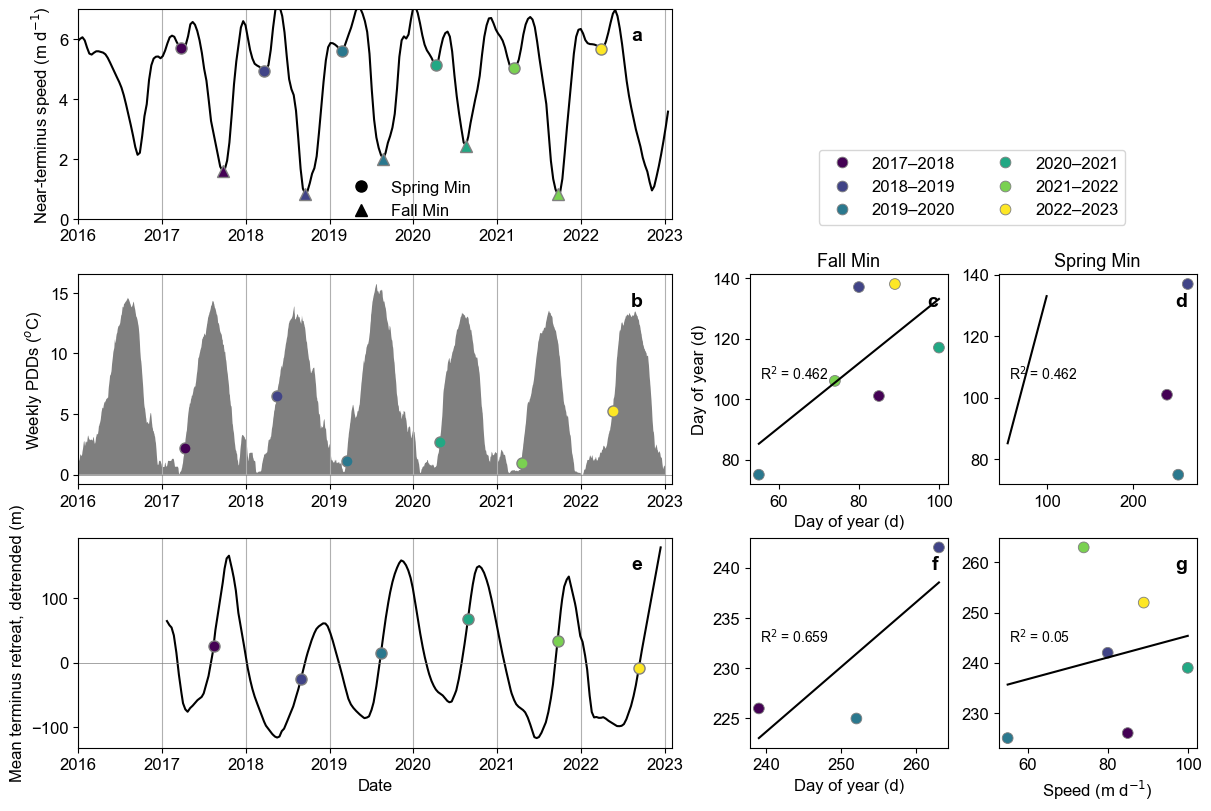

Figure saved to file: /Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/speed_peaks_vs_PDD_terminus.png


In [15]:
## Plot time series
fontsize=12
markersize=8
plt.rcParams.update({'font.sans-serif': 'Arial', 'font.size': fontsize})
fig, ax = plt.subplots(3, 3, figsize=(12,8), gridspec_kw={'width_ratios': [3,1,1]}, constrained_layout=True)

# -----Time series
# Speed
ax[0,0].plot(v_term['Date'], v_term['Mean'], '-k')
for date, summer_peak, color in v_summer_peaks[['Date', 'Mean', 'color']].values:
    ax[0,0].plot(date, summer_peak, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
for date, min, color in v_mins[['Date', 'Mean', 'color']].values:
    if date.year < 2022:
        ax[0,0].plot(date, min, '^', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
# ax[0,0].plot(np.datetime64('2000-01-01'), 0, 'o', color='k', markersize=markersize, label='Summer peak')
# ax[0,0].plot(np.datetime64('2000-01-01'), 0, '^', color='k', markersize=markersize, label='Winter peak')
ax[0,0].plot(np.datetime64('2000-01-01'), 0, 'o', color='k', markersize=markersize, label='Spring Min')
ax[0,0].plot(np.datetime64('2000-01-01'), 0, '^', color='k', markersize=markersize, label='Fall Min')
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', frameon=False, bbox_to_anchor=[0.2, 0.6, 0.2, 0.2])
ax[0,0].set_ylim(0,7)
ax[0,0].set_ylabel('Near-terminus speed (m d$^{-1}$)')

# PDDs
#weekly PDD
# ax[1,0].fill_between(air['Date'], np.zeros(len(air)), air['weekly_PDD'], 
#                      facecolor='k', edgecolor=None, alpha=0.5)
# for date, pdd, color in pdd_peaks[['Date', 'weekly_PDD', 'color']].values:
#      ax[1,0].plot(date, pdd, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
# ax[1,0].set_ylabel('Weekly PDDs ($^o$C)')

#Smoothed PDD
ax[1,0].fill_between(air['Date'], np.zeros(len(air)), air['smooth_PDD'], 
                     facecolor='k', edgecolor=None, alpha=0.5)
for date, pdd, color in pdd_peaks[['Date', 'smooth_PDD', 'color']].values:
     ax[1,0].plot(date, pdd, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
ax[1,0].set_ylabel('Weekly PDDs ($^o$C)')


# cumulative PDD
# ax[1,0].fill_between(air['Date'], np.zeros(len(air)), air['cumulative_PDD'], 
#                      facecolor='k', edgecolor=None, alpha=0.5)
# for date, pdd, color in pdd_peaks[['Date', 'cumulative_PDD', 'color']].values:
#      ax[1,0].plot(date, pdd, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
# ax[1,0].set_ylabel('Cumulative PDDs ($^o$C)')

ax[2,0].plot(term['Date'], term['Mean_retreat_detrended_m'], '-k')
for date, retreat, color in term_peaks[['Date', 'Mean_retreat_detrended_m', 'color']].values:
    ax[2,0].plot(date, retreat, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
# for index, row in term_peaks.iterrows():
#     if row['Peak_Type'] == 'Max Retreat':
#         ax[2, 0].plot(row['Date'], row['Mean_retreat_detrended_m'], 'o', 
#                       markerfacecolor=row['color'],  # Use the color from the row
#                       markeredgecolor='gray', 
#                       linewidth=0.5, markersize=markersize, 
#                       label='Retreat Peaks' if index == 0 else "")
#     elif row['Peak_Type'] == 'Min Advance':
#         ax[2, 0].plot(row['Date'], row['Mean_retreat_detrended_m'], '^', 
#                       markerfacecolor=row['color'],  # Use the color from the row
#                       markeredgecolor='gray', 
#                       linewidth=0.5, markersize=markersize, 
#                       label='Advance Peaks' if index == 0 else "")
        
ax[2,0].set_ylabel('Mean terminus retreat, detrended (m)')
ax[2,0].set_xlabel('Date')
# adjust axes
xmin, xmax = np.datetime64('2016-01-01'), np.datetime64('2023-02-01')
for axis in ax[:,0]:
    axis.set_xlim(xmin, xmax)
    axis.xaxis.grid(True)
    axis.hlines(0, xmin, xmax, linewidth=0.5, color='grey')

# -----Peak regressions
def linear_fit(df):
    X, y = df.dropna().values[:,0], df.dropna().values[:,1]
    X = X.reshape(-1,1)
    lr = LinearRegression().fit(X,y)
    score = lr.score(X,y)
    Xpred = np.linspace(np.min(X), np.max(X), 100).reshape(-1,1)
    ypred = lr.predict(Xpred)
    return Xpred, ypred, score
def plot_score(axis, score):
    axis.text(0.05, 0.5, f'R$^2$ = {np.round(score,3)}', transform=axis.transAxes, ha='left', fontsize=fontsize-2)
    return
# PDD-summer
sns.scatterplot(data=peaks_merged, x='day_of_year_vsum', y='day_of_year_PDD', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', ax=ax[1,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['day_of_year_vsum', 'day_of_year_PDD']])
ax[1,1].plot(Xpred, ypred, '-k')
plot_score(ax[1,1], score)
ax[1,1].set_xlabel('Day of year (d)')
ax[1,1].set_ylabel('Day of year (d)')
# ax[1,1].set_title('Summer peak speed', fontsize=fontsize+1)
ax[1,1].set_title('Fall Min', fontsize=fontsize+1)

# Add legend for years
handles, labels = ax[1,1].get_legend_handles_labels()
ax[1,1].legend().remove()
labels = ['2017–2018', '2018–2019', '2019–2020', '2020–2021', '2021–2022', '2022–2023']
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=[0.74, 0.63, 0.2, 0.2], ncols=2)

# PDD-winter
sns.scatterplot(data=peaks_merged, x='day_of_year_vmin', y='day_of_year_PDD', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[1,2]) 
Xpred, ypred, score = linear_fit(peaks_merged[['day_of_year_vsum', 'day_of_year_PDD']])
ax[1,2].plot(Xpred, ypred, '-k')
plot_score(ax[1,2], score)
ax[1,2].set_xlabel('')
ax[1,2].set_ylabel('')
# ax[1,2].set_title('Winter peak speed', fontsize=fontsize+1)
ax[1,2].set_title('Spring Min', fontsize=fontsize+1)


sns.scatterplot(data=peaks_merged, x='day_of_year_vmin', y='day_of_year_retreat', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[2,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['day_of_year_vmin', 'day_of_year_retreat']])
ax[2,1].plot(Xpred, ypred, '-k')
plot_score(ax[2,1], score)
ax[2,1].set_ylabel('')
ax[2,1].set_xlabel('Day of year (d)')


sns.scatterplot(data=peaks_merged, x='day_of_year_vsum', y='day_of_year_retreat', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[2,2]) 
Xpred, ypred, score = linear_fit(peaks_merged[['day_of_year_vsum', 'day_of_year_retreat']])
ax[2,2].plot(Xpred, ypred, '-k')
plot_score(ax[2,2], score)
ax[2,2].set_ylabel('')
ax[2,2].set_xlabel('Speed (m d$^{-1}$)')

# Add panel labels
def plot_panel_label(axis, label):
    axis.text(0.95, 0.85, label, transform=axis.transAxes,
              ha='right', fontweight='bold', fontsize=fontsize+2)
    return
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
for axis, label in list(zip([ax[0,0], 
                             ax[1,0], ax[1,1], ax[1,2],
                             ax[2,0], ax[2,1], ax[2,2]], labels)):
    plot_panel_label(axis, label)

# Remove unused axes
ax[0,1].remove()
ax[0,2].remove()

# fig.tight_layout()
plt.show()

# Save figure
fig_fn = os.path.join(out_path, 'speed_peaks_vs_PDD_terminus.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

In [90]:
## Calculate annual peaks
# Add fake year columns (starting in April)
def add_fake_year_column(df):
    def calculate_fake_year(month, year):
        if month <= 0:
            return year-1
        else:
            return year
    months, years = df['Date'].dt.month.values, df['Date'].dt.year.values
    df['fake_year'] = [calculate_fake_year(month, year) 
                        for month, year in list(zip(months, years))]
    return df
def subset_fake_years_add_color(df):
    df = df.loc[(df['fake_year'] >= 2017) & (df['fake_year'] <= 2022)]
    df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
    return df

# PDDs
air = add_fake_year_column(air)
air['fake_year'] = air['fake_year'] + 1
def calculate_pdd(temp):
    if temp > 0:
        return temp
    else:
        return 0

# Assuming 'air' DataFrame is already defined and 'calculate_pdd' function is available

# Define year and biweek for grouping
air['Biweek'] = ((air['Date'].dt.isocalendar().week - 1) // 2) + 1  # Grouping into biweekly intervals
air['Year'] = air['Date'].dt.year

# Add a column for fake year and calculate PDD
air['fake_year'] = air['Date'].dt.year
air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)

# Calculate biweekly average PDD and the first date of each biweek
air['biweekly_PDD'] = air.groupby(['Year', 'Biweek'])['PDD'].transform('mean')
air['day_of_year_PDD'] = air.groupby(['Year', 'Biweek'])['Date'].transform('first')

# Convert 'day_of_year_PDD' to the day of the year
air['day_of_year_PDD'] = air['day_of_year_PDD'].dt.dayofyear

# Optional: drop intermediate columns
air = air.drop(columns=['Biweek', 'Year'])

# Create a mask to filter for biweeks meeting the threshold within the first six months
mask = (air['biweekly_PDD'] >= 4) & (air['Date'].dt.month <= 7)

# Find the first occurrence in each fake_year where the threshold is met
pdd_peaks = (
    air[mask]
    .groupby('fake_year')
    .apply(lambda x: x.loc[x['Date'].idxmin()])
    .reset_index(drop=True)
)

# Add color with the subset_fake_years_add_color function
pdd_peaks = subset_fake_years_add_color(pdd_peaks)
 
# Max terminus advance
term = add_fake_year_column(term)
ipeaks = term.groupby(term['Date'].dt.year)['Mean_retreat_detrended_m'].idxmax()
term_peaks = term.loc[ipeaks, ['Date', 'Mean_retreat_detrended_m', 'fake_year']].reset_index(drop=True)
term_peaks['day_of_year_term'] = term_peaks['Date'].dt.dayofyear
term_peaks = subset_fake_years_add_color(term_peaks)

# Speed inflection point
v_term = add_fake_year_column(v_term)
v_term['v_gradient'] = v_term['Mean'].diff() / v_term['Date'].diff().dt.days
iinf = v_term.groupby(v_term['Date'].dt.year)['v_gradient'].idxmax()
v_inf = v_term.loc[iinf, ['Date', 'Mean', 'v_gradient', 'fake_year']].reset_index(drop=True)
v_inf['day_of_year_vinf'] = v_inf['Date'].dt.dayofyear
v_inf = subset_fake_years_add_color(v_inf)

# min between winter and summer
v_term_summer = v_term.loc[(v_term['Date'].dt.month >= 2) & ((v_term['Date'].dt.month <= 5))]

ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['Mean'].idxmin().values
#ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['v_gradient'].idxmax()

# Extract the day of the year instead of the actual date for each minimum velocity
v_summer_peaks = v_term_summer.loc[ipeaks].reset_index(drop=True)
v_summer_peaks['day_of_year_vsum'] = v_summer_peaks['Date'].dt.dayofyear

# Drop the original 'Date' column if you only need the day of the year
v_summer_peaks = v_summer_peaks[['day_of_year_vsum', 'Date', 'Mean', 'fake_year']]

# Optionally, add color or additional processing with the subset_fake_years_add_color function
v_summer_peaks = subset_fake_years_add_color(v_summer_peaks)

# Winter speed min
v_term_winter['Year'] = v_term_winter['Date'].dt.year
v_term_winter = v_term.loc[(v_term['Date'].dt.month >= 12) | ((v_term['Date'].dt.month <= 5))]
ipeaks = v_term_winter.groupby(v_term_winter['fake_year'])['Mean'].idxmin().values

v_winter_peaks = v_term_winter.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
v_winter_peaks = subset_fake_years_add_color(v_winter_peaks)


# Merge into one dataframe for regression plotting
peaks_merged = (v_inf[['fake_year', 'color', 'Mean', 'day_of_year_vinf']].merge(
    pdd_peaks[['fake_year', 'color', 'day_of_year_PDD', 'biweekly_PDD']].merge(
    term_peaks[['fake_year', 'Mean_retreat_detrended_m', 'day_of_year_term']].merge(
        v_summer_peaks[['fake_year', 'Mean', 'day_of_year_vsum']].merge(
            v_winter_peaks[['fake_year', 'Mean']], on='fake_year', how='outer', suffixes=['_summer_peak', '_winter_peak']),
        on='fake_year', how='outer'),
    on='fake_year', how='outer')))

# Set winter 2022 observations to NaN (probably not capturing true peaks)
peaks_merged.loc[peaks_merged['fake_year']==2022, ['Mean_winter_peak']] = np.nan
peaks_merged

/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_1022/1998655312.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x['Date'].idxmin()])
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_1022/1998655312.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_1022/1998655312.py:15: SettingWithCopyWa

,fake_year,color,Mean,day_of_year_vinf,day_of_year_PDD,biweekly_PDD,Mean_retreat_detrended_m,day_of_year_term,Mean_summer_peak,day_of_year_vsum,Mean_winter_peak
0,2017,"(0.267004, 0.004874, 0.329415, 1.0)",4.500676,315,100,5.951919,165.108281,293,5.696602,85,5.442003
1,2018,"(0.253935, 0.265254, 0.529983, 1.0)",4.584499,340,99,4.944168,60.540930,338,4.943701,80,4.584499
2,2019,"(0.163625, 0.471133, 0.558148, 1.0)",5.412453,305,70,5.757740,157.846567,313,5.618402,55,5.618402
3,2020,"(0.134692, 0.658636, 0.517649, 1.0)",5.477207,300,111,5.833389,149.112626,288,5.129589,100,5.129589
4,2021,"(0.477504, 0.821444, 0.318195, 1.0)",3.065779,304,102,5.145728,132.872476,312,5.041533,74,5.041533
5,2022,"(0.993248, 0.906157, 0.143936, 1.0)",2.593615,359,115,5.319648,177.977022,347,5.668544,89,NaN


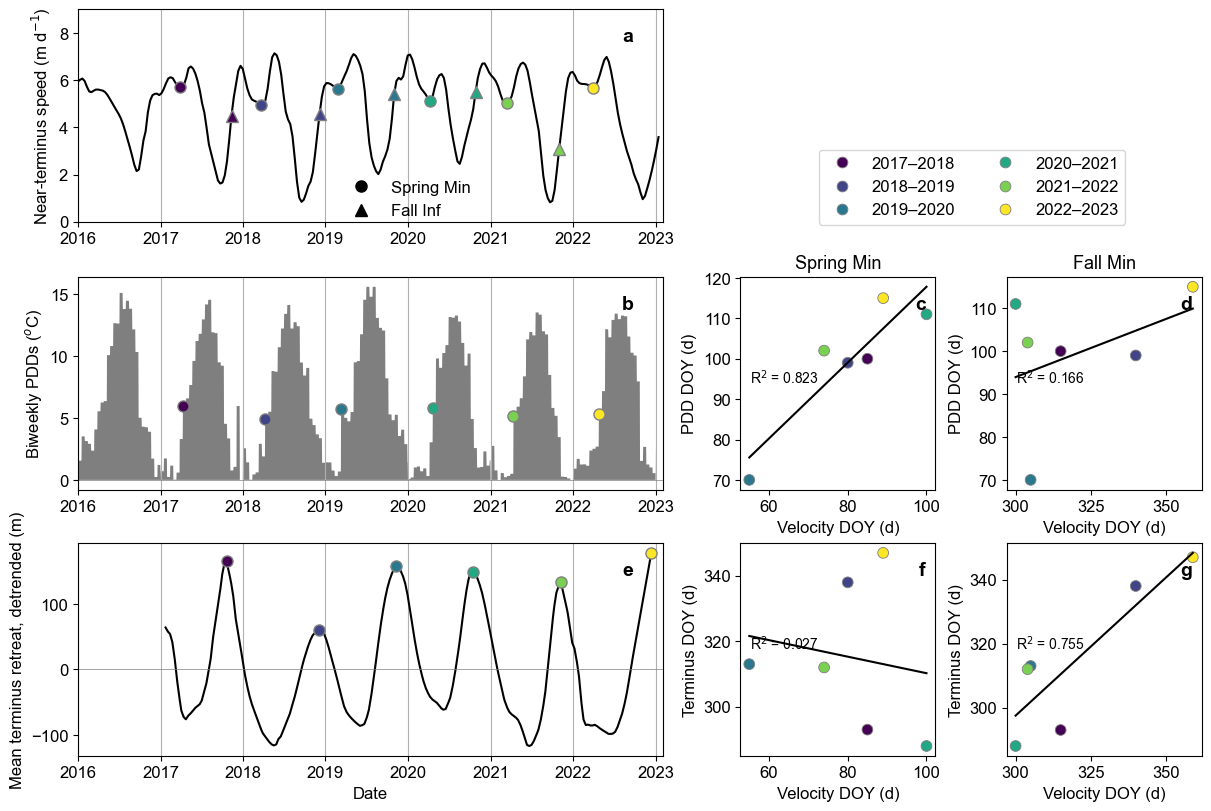

Figure saved to file: /Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/speed_peaks_vs_PDD_terminus.png


In [91]:
## Plot time series
fontsize=12
markersize=8
plt.rcParams.update({'font.sans-serif': 'Arial', 'font.size': fontsize})
fig, ax = plt.subplots(3, 3, figsize=(12,8), gridspec_kw={'width_ratios': [3,1,1]}, constrained_layout=True)

# -----Time series
# Speed
ax[0,0].plot(v_term['Date'], v_term['Mean'], '-k')
for date, summer_peak, color in v_summer_peaks[['Date', 'Mean', 'color']].values:
    ax[0,0].plot(date, summer_peak, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
for date, min, color in v_inf[['Date', 'Mean', 'color']].values:
    if date.year < 2022:
        ax[0,0].plot(date, min, '^', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
# ax[0,0].plot(np.datetime64('2000-01-01'), 0, 'o', color='k', markersize=markersize, label='Summer peak')
# ax[0,0].plot(np.datetime64('2000-01-01'), 0, '^', color='k', markersize=markersize, label='Winter peak')
ax[0,0].plot(np.datetime64('2000-01-01'), 0, 'o', color='k', markersize=markersize, label='Spring Min')
ax[0,0].plot(np.datetime64('2000-01-01'), 0, '^', color='k', markersize=markersize, label='Fall Inf')
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', frameon=False, bbox_to_anchor=[0.2, 0.6, 0.2, 0.2])
ax[0,0].set_ylim(0,9)
ax[0,0].set_ylabel('Near-terminus speed (m d$^{-1}$)')

#Smoothed PDD
ax[1,0].fill_between(air['Date'], np.zeros(len(air)), air['biweekly_PDD'], 
                     facecolor='k', edgecolor=None, alpha=0.5)
for date, pdd, color in pdd_peaks[['Date', 'biweekly_PDD', 'color']].values:
     ax[1,0].plot(date, pdd, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
ax[1,0].set_ylabel('Biweekly PDDs ($^o$C)')


ax[2,0].plot(term['Date'], term['Mean_retreat_detrended_m'], '-k')
for date, retreat, color in term_peaks[['Date', 'Mean_retreat_detrended_m', 'color']].values:
    ax[2,0].plot(date, retreat, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)

ax[2,0].set_ylabel('Mean terminus retreat, detrended (m)')
ax[2,0].set_xlabel('Date')
# adjust axes
xmin, xmax = np.datetime64('2016-01-01'), np.datetime64('2023-02-01')
for axis in ax[:,0]:
    axis.set_xlim(xmin, xmax)
    axis.xaxis.grid(True)
    axis.hlines(0, xmin, xmax, linewidth=0.5, color='grey')

# -----Peak regressions
def linear_fit(df):
    X, y = df.dropna().values[:,0], df.dropna().values[:,1]
    X = X.reshape(-1,1)
    lr = LinearRegression().fit(X,y)
    score = lr.score(X,y)
    Xpred = np.linspace(np.min(X), np.max(X), 100).reshape(-1,1)
    ypred = lr.predict(Xpred)
    return Xpred, ypred, score
def plot_score(axis, score):
    axis.text(0.05, 0.5, f'R$^2$ = {np.round(score,3)}', transform=axis.transAxes, ha='left', fontsize=fontsize-2)
    return
# PDD-Spring
sns.scatterplot(data=peaks_merged, x='day_of_year_vsum', y='day_of_year_PDD', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', ax=ax[1,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['day_of_year_vsum', 'day_of_year_PDD']])
ax[1,1].plot(Xpred, ypred, '-k')
plot_score(ax[1,1], score)
# ax[1,1].set_xlabel('Day of year (d)')
# ax[1,1].set_ylabel('Day of year (d)')
ax[1,1].set_xlabel('Velocity DOY (d)')
ax[1,1].set_ylabel('PDD DOY (d)')

ax[1,1].set_title('Spring Min', fontsize=fontsize+1)

# Add legend for years
handles, labels = ax[1,1].get_legend_handles_labels()
ax[1,1].legend().remove()
labels = ['2017–2018', '2018–2019', '2019–2020', '2020–2021', '2021–2022', '2022–2023']
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=[0.74, 0.63, 0.2, 0.2], ncols=2)

# PDD-Fall
sns.scatterplot(data=peaks_merged, x='day_of_year_vinf', y='day_of_year_PDD', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[1,2]) 
Xpred, ypred, score = linear_fit(peaks_merged[['day_of_year_vinf', 'day_of_year_PDD']])
ax[1,2].plot(Xpred, ypred, '-k')
plot_score(ax[1,2], score)
ax[1,2].set_xlabel('')
ax[1,2].set_ylabel('')
ax[1,2].set_title('Fall Min', fontsize=fontsize+1)
ax[1,2].set_xlabel('Velocity DOY (d)')
ax[1,2].set_ylabel('PDD DOY (d)')

# Terminus - Fall
sns.scatterplot(data=peaks_merged, x='day_of_year_vinf', y='day_of_year_term', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[2,2]) 
Xpred, ypred, score = linear_fit(peaks_merged[['day_of_year_vinf', 'day_of_year_term']])
ax[2,2].plot(Xpred, ypred, '-k')
plot_score(ax[2,2], score)
# ax[2,2].set_ylabel('')
# ax[2,2].set_xlabel('Speed (m d$^{-1}$')
ax[2,2].set_xlabel('Velocity DOY (d)')
ax[2,2].set_ylabel('Terminus DOY (d)')


# Terminus - Spring
sns.scatterplot(data=peaks_merged, x='day_of_year_vsum', y='day_of_year_term', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[2,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['day_of_year_vsum', 'day_of_year_term']])
ax[2,1].plot(Xpred, ypred, '-k')
plot_score(ax[2,1], score)
# ax[2,1].set_ylabel('')
# ax[2,1].set_xlabel('Speed (m d$^{-1}$)')
ax[2,1].set_xlabel('Velocity DOY (d)')
ax[2,1].set_ylabel('Terminus DOY (d)')

# Add panel labels
def plot_panel_label(axis, label):
    axis.text(0.95, 0.85, label, transform=axis.transAxes,
              ha='right', fontweight='bold', fontsize=fontsize+2)
    return
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
for axis, label in list(zip([ax[0,0], 
                             ax[1,0], ax[1,1], ax[1,2],
                             ax[2,0], ax[2,1], ax[2,2]], labels)):
    plot_panel_label(axis, label)

# Remove unused axes
ax[0,1].remove()
ax[0,2].remove()

# fig.tight_layout()
plt.show()

# Save figure
fig_fn = os.path.join(out_path, 'speed_peaks_vs_PDD_terminus.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)